# **XAI** Methods Implementation in Deep Learning Models for **Credit Card Fraud Detection** 

## Overview

This notebook applies Explainable AI (XAI) methods to analyze Deep Learning models for Credit Card Fraud detection. By implementing **SHAP**, **LIME**, and **Anchors**, I transformed "black box" neural networks into transparent, interpretable systems that provide clear explanations for fraud predictions. 

All necessary models, dataset, libraries are imported and should be ready to use, with pre-trained models available in the `architectures/` folder.

- **Github Repos:** [Credit-Card-Transaction-Fraud-Detection-Using-Explainable-AI](https://github.com/ThongLai/Credit-Card-Transaction-Fraud-Detection-Using-Explainable-AI)

- **Run live notebook:** [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ThongLai/Credit-Card-Transaction-Fraud-Detection-Using-Explainable-AI/main?urlpath=%2Fdoc%2Ftree%2FXAI_methods.ipynb)

- **Models: [architectures](https://github.com/ThongLai/Credit-Card-Transaction-Fraud-Detection-Using-Explainable-AI/tree/main/architectures)**<a name="models" id="models"></a>

---

**Author:** Thong Minh Lai 

**Last Updated:** 04/2025

## Description

**What This Notebook Contains:**

- **Pre-trained Black Box Models**: Collection of pre-trained fraud detection models
- **Global Interpretability**: Understanding overall model behavior and feature importance
- **Local Explanations**: Detailed analysis of individual transaction predictions
- **Visual Insights**: Interactive visualisations showing why specific transactions are flagged
- **Comparative Analysis**: Multiple XAI techniques applied to the same predictions

**Key XAI Techniques Implemented**

1. **SHAP (SHapley Additive exPlanations)** 🎲
   - Measures each feature's contribution to predictions using game theory
   - Provides both global importance and transaction-specific explanations

2. **LIME (Local Interpretable Model-agnostic Explanations)** 🍋
   - Creates simple models that approximate complex models locally
   - Shows which features influenced specific fraud predictions

3. **Anchors** ⚓
   - Generates clear IF-THEN rules that explain model decisions
   - Focuses on high-precision, easy-to-understand explanations

**Why This Matters**

Understanding fraud detection models through explainable AI is essential in today's financial landscape. Financial institutions face increasing regulatory pressure for transparency in automated decision-making [[1](https://ijsra.net/content/explainable-ai-financial-technologies-balancing-innovation-regulatory-compliance)], while simultaneously needing to improve model performance to combat sophisticated fraud techniques [[2](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4980350#:~:text=This%20study%20examines%20the,consisting%20of%20284%2C807%20transactions)]. Explainable fraud detection creates a crucial bridge between complex AI systems and human oversight, enabling compliance officers to validate regulatory adherence and fraud analysts to verify and refine AI-flagged transactions with their domain expertise [[3](https://www.researchgate.net/publication/226538138_Trust_and_Stakeholder_Theory_Trustworthiness_in_the_Organisation-Stakeholder_Relationship#:~:text=Trust%20is%20a%20fundamental,stakeholders%20within%20the%20organization–stakeholder)]. This transparency builds stakeholder trust by demonstrating that fraud decisions aren't emerging from an algorithmic "black box" but are based on identifiable, reasonable patterns that can be communicated to customers, auditors, and management. As financial fraud becomes more sophisticated, this human-AI partnership represents the most effective defense, combining the pattern-recognition capabilities of neural networks with human judgment and regulatory compliance requirements.


## Global Setting Variables

In [10]:
MODEL_PATH = 'architectures/'
DATA_PATH = 'data/'
VISUALISATION_PATH = 'visualisation/'
MAKE_PREDICTIONS = False # Make predictions from loaded models, leave as `Fasle` to load predictions from `predictions.csv`
LOAD_METRICS = True # Compute XAI Metrics across models and methods (might take some time), leave as `False` to load from `xai_methods.json`
SAVE_FIGURES = False # Save figure into file after plotting
RANDOM_SEED = 42 # Set to `None` for the generator uses the current system time.

## Importing the necessary packages

In [11]:
# If you are running on `Binder`, then it is no need to set up the packages again
# %pip install -r requirements.txt

# ---OR---

# %pip install tensorflow==2.10.1 numpy==1.26.4 pandas scikit-learn imblearn scipy matplotlib seaborn requests tqdm shap lime anchor-exp

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy.stats import spearmanr

# XAI
import shap
from lime import lime_tabular
from anchor import anchor_tabular

import os
import time
from tqdm import tqdm
from IPython.display import display
import utils

import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

np.random.seed(RANDOM_SEED)
plt.interactive(True)
sns.set(style="whitegrid")

Python Version: `3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]`
Base Python location: `C:\Users\LMT\AppData\Local\Programs\Python\Python310`
Current Environment location: `.venv_xai_fraud_detection`

Tensorflow version: `2.10.1`
CUDNN version: `64_8`
CUDA version: `64_112`
Num GPUs Available: 1


## Import test dataset and process data

### Download dataset

In [13]:
utils.download_dataset_from_kaggle('fraudTrain.csv')
utils.download_dataset_from_kaggle('fraudTest.csv')

URL: https://www.kaggle.com/api/v1/datasets/download/kartik2112/fraud-detection/fraudTrain.csv
File `data/fraudTrain.csv` already exists.
URL: https://www.kaggle.com/api/v1/datasets/download/kartik2112/fraud-detection/fraudTest.csv
File `data/fraudTest.csv` already exists.


### Read data

In [14]:
data_train = pd.read_csv(os.path.join(DATA_PATH, 'fraudTrain.csv'), index_col=0)
data_test = pd.read_csv(os.path.join(DATA_PATH, 'fraudTest.csv'), index_col=0)

### Process data

In [15]:
data_train = utils.feature_engineering(data_train)
X_train, y_train, data_train, transformations = utils.pre_processing(data_train)

data_test = utils.feature_engineering(data_test)
X_test, y_test, data_test, _ = utils.pre_processing(data_test, transformations, isTestSet=True)

Ordinal-Encoding is applied for `['merchant', 'category', 'gender', 'age_group', 'day_of_week']`
SMOTE is applied
Ordinal-Encoding is applied for `['merchant', 'category', 'gender', 'age_group', 'day_of_week']`


In [16]:
data_test['is_fraud'].value_counts()

0    553574
1      2145
Name: is_fraud, dtype: int64

## Feature Description Table

| **Field Name**   | **Description**                                                             |
|------------------|-----------------------------------------------------------------------------|
| **merchant**     | Name of merchant where transaction occurred (e.g., *Starbucks*)             |
| **category**     | Category of merchant (e.g., *retail*, *food*, etc.)                         |
| **amt**          | Amount of transaction (e.g., *$25.50*)                                      |
| **gender**       | Gender of credit card holder (e.g., *Male*, *Female*)                       |
| **lat**          | Latitude location of credit card holder (e.g., *34.0522*)                   |
| **long**         | Longitude location of credit card holder (e.g., *-118.2437*)                |
| **city_pop**     | Population of credit card holder's city (e.g., *4000000*)                   |
| **merch_lat**    | Latitude location of merchant (e.g., *34.0522*)                             |
| **merch_long**   | Longitude location of merchant (e.g., *-118.2437*)                          |
| **age**          | Age of credit card holder (derived from dob, e.g., *28*)                    |
| **age_group**    | Age group category of credit card holder (e.g., *20-29*, *30-39*)           |
| **dist**         | Distance between merchant and card holder locations (e.g., *5.2 miles*)     |
| **hour**         | Hour of day when transaction occurred (e.g., *14*)                          |
| **day_of_week**  | Day of the week when transaction occurred (e.g., *Monday*)                  |
| **month**        | Month when transaction occurred (e.g., *April*)                             |

## Features Distributions Visualisation

### Plot numerical features

In [17]:
def plot_numerical_distributions(data, sample_size=1000000):
    """
    Create distribution plots for numerical features, comparing fraud vs non-fraud transactions.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The dataset containing both numerical features and 'is_fraud' column
    sample_size : int, optional (default=100000)
        Number of rows to sample for visualisation to handle large datasets
    """
    # Sample data for visualisation to improve performance
    data_sample = data.sample(n=min(sample_size, len(data)))

    # Get numerical columns excluding the target variable
    numerical_cols = data.drop('is_fraud', axis=1).select_dtypes(include='number').columns

    # Create a grid of subplots
    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    fig.suptitle('Numerical Features Distribution', y=1.02, fontsize=16)
    
    # Plot each numerical feature
    for idx, col in enumerate(numerical_cols):
        row = idx // n_cols
        col_idx = idx % n_cols
        ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
        
        # Plot histogram for both fraud and non-fraud
        ax.hist(data_sample[data_sample['is_fraud']==0][col], 
                bins=50, alpha=0.5, label='Non-Fraud', density=True, color='green')
        ax.hist(data_sample[data_sample['is_fraud']==1][col], 
                bins=50, alpha=0.5, label='Fraud', density=True, color='red')
        
        ax.set_title(f'{col} Distribution')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
    
    # Hide empty subplots if any
    for idx in range(len(numerical_cols), n_rows * n_cols):
        row = idx // n_cols
        col_idx = idx % n_cols
        ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.savefig(os.path.join(VISUALISATION_PATH, f'numerical_distributions.png'), dpi=600, bbox_inches='tight') if SAVE_FIGURES else None
    plt.show()

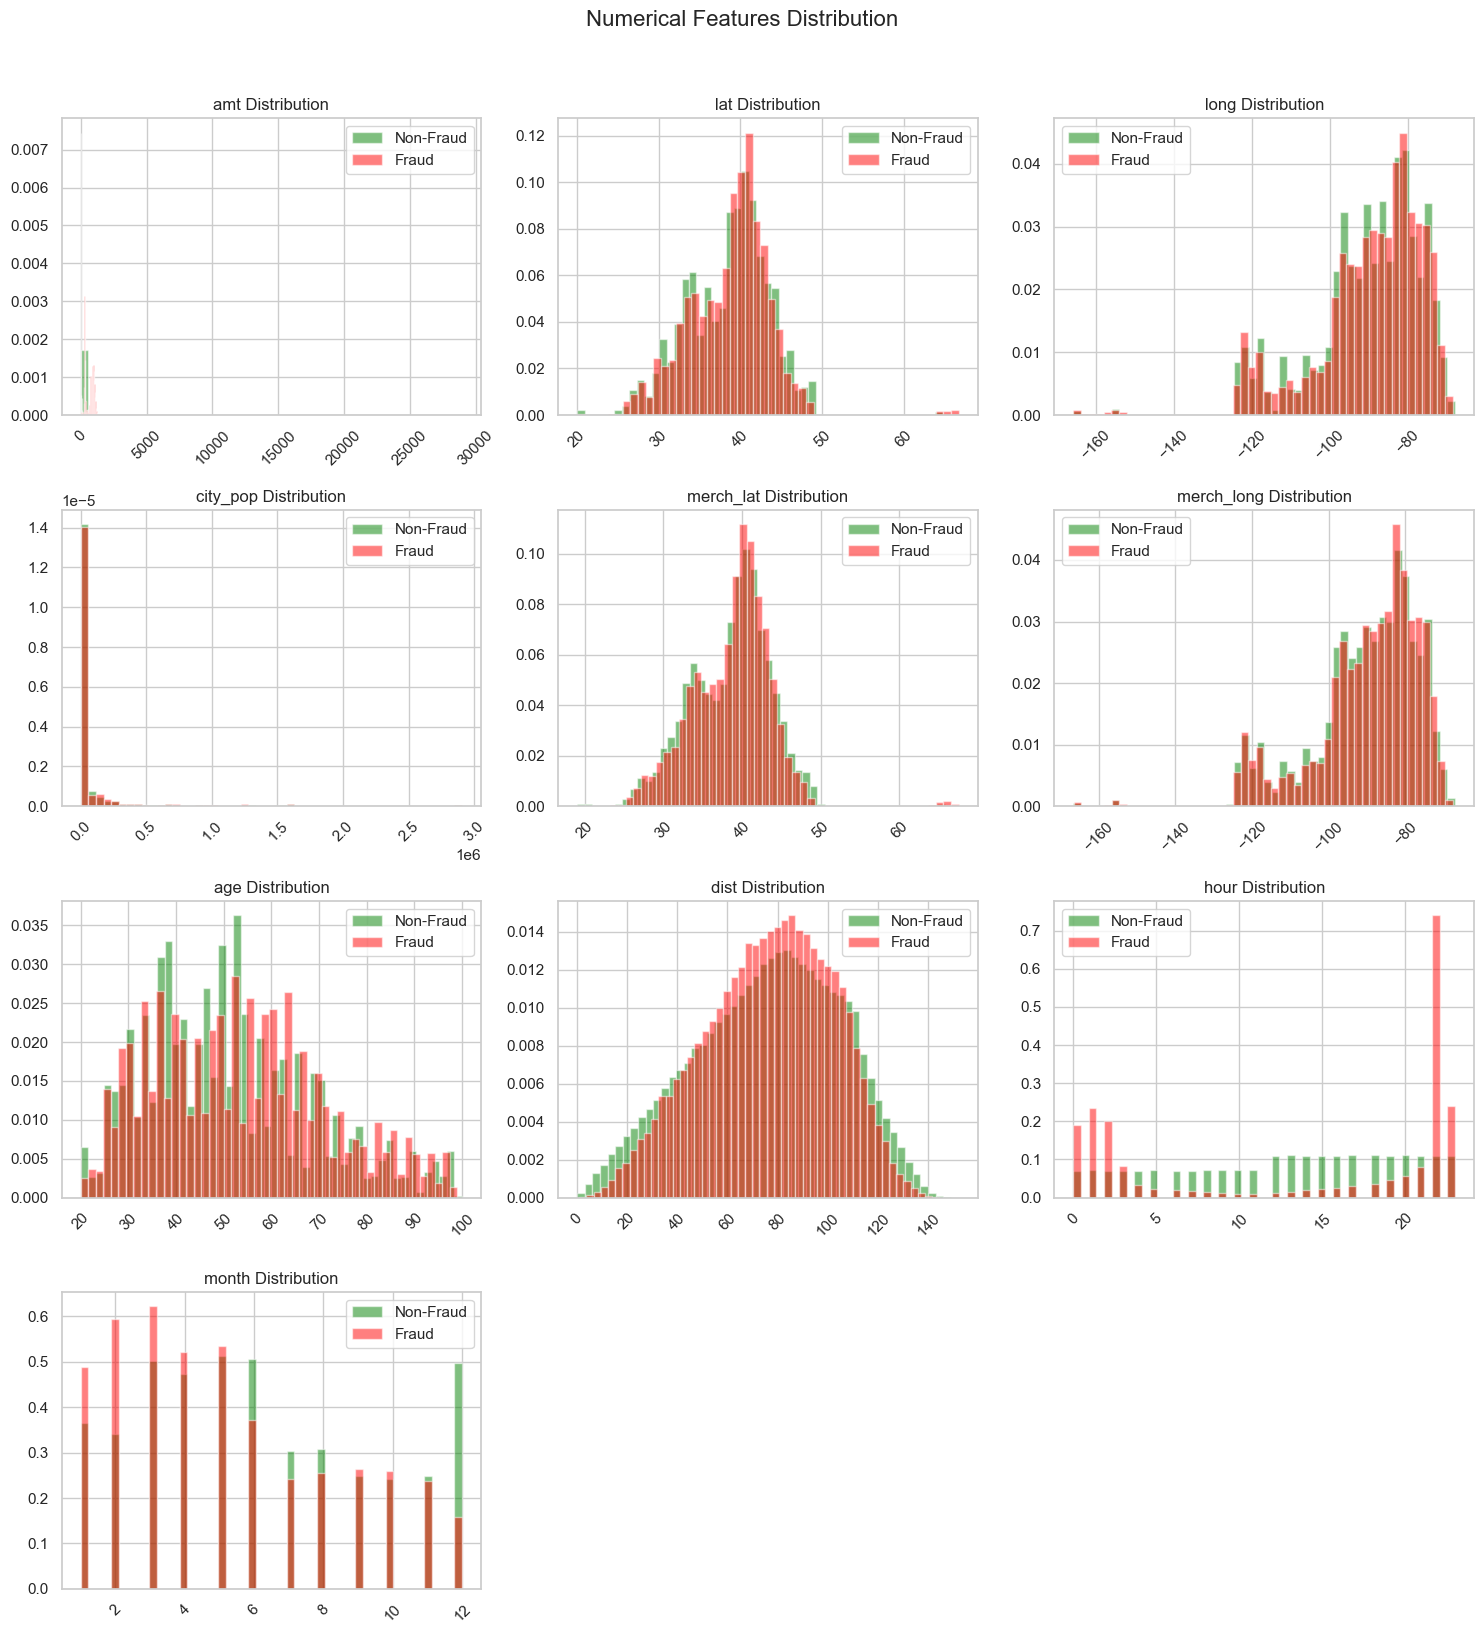

In [18]:
plot_numerical_distributions(data_train)

### Plot categorical features

In [19]:
def plot_categorical_distributions(data, sample_size=100000):
    """
    Create distribution plots for categorical features, comparing fraud vs non-fraud transactions.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The dataset containing both categorical features and 'is_fraud' column
    sample_size : int, optional (default=100000)
        Number of rows to sample for visualisation to handle large datasets
    """
    # Get categorical columns
    categorical_cols = data.drop('merchant', axis=1).select_dtypes(include=['category']).columns
    
    # Sample data for visualisation to improve performance
    data_sample = data.sample(n=min(sample_size, len(data)), random_state=42)
    
    # Create a grid of subplots
    fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(12, 4*len(categorical_cols)))
    fig.suptitle('Categorical Features Distribution', y=1.02, fontsize=16)
    
    # Plot each categorical feature
    for idx, col in enumerate(categorical_cols):
        # Calculate value counts for fraud and non-fraud
        fraud_counts = data_sample[data_sample['is_fraud']==1][col].value_counts()
        non_fraud_counts = data_sample[data_sample['is_fraud']==0][col].value_counts()
        
        # Plot bars
        ax = axes[idx] if len(categorical_cols) > 1 else axes
        x = np.arange(len(fraud_counts.index))
        width = 0.35

        ax.bar(x + width/2, fraud_counts, width, label='Fraud', alpha=0.5, color='red')
        ax.bar(x - width/2, non_fraud_counts, width, label='Non-Fraud', alpha=0.5, color='green')
        
        ax.set_title(f'{col} Distribution')
        ax.set_xticks(x)
        ax.set_xticklabels(fraud_counts.index, rotation=45)
        ax.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(VISUALISATION_PATH, f'categorical_distributions.png'), dpi=600, bbox_inches='tight') if SAVE_FIGURES else None
    plt.show()

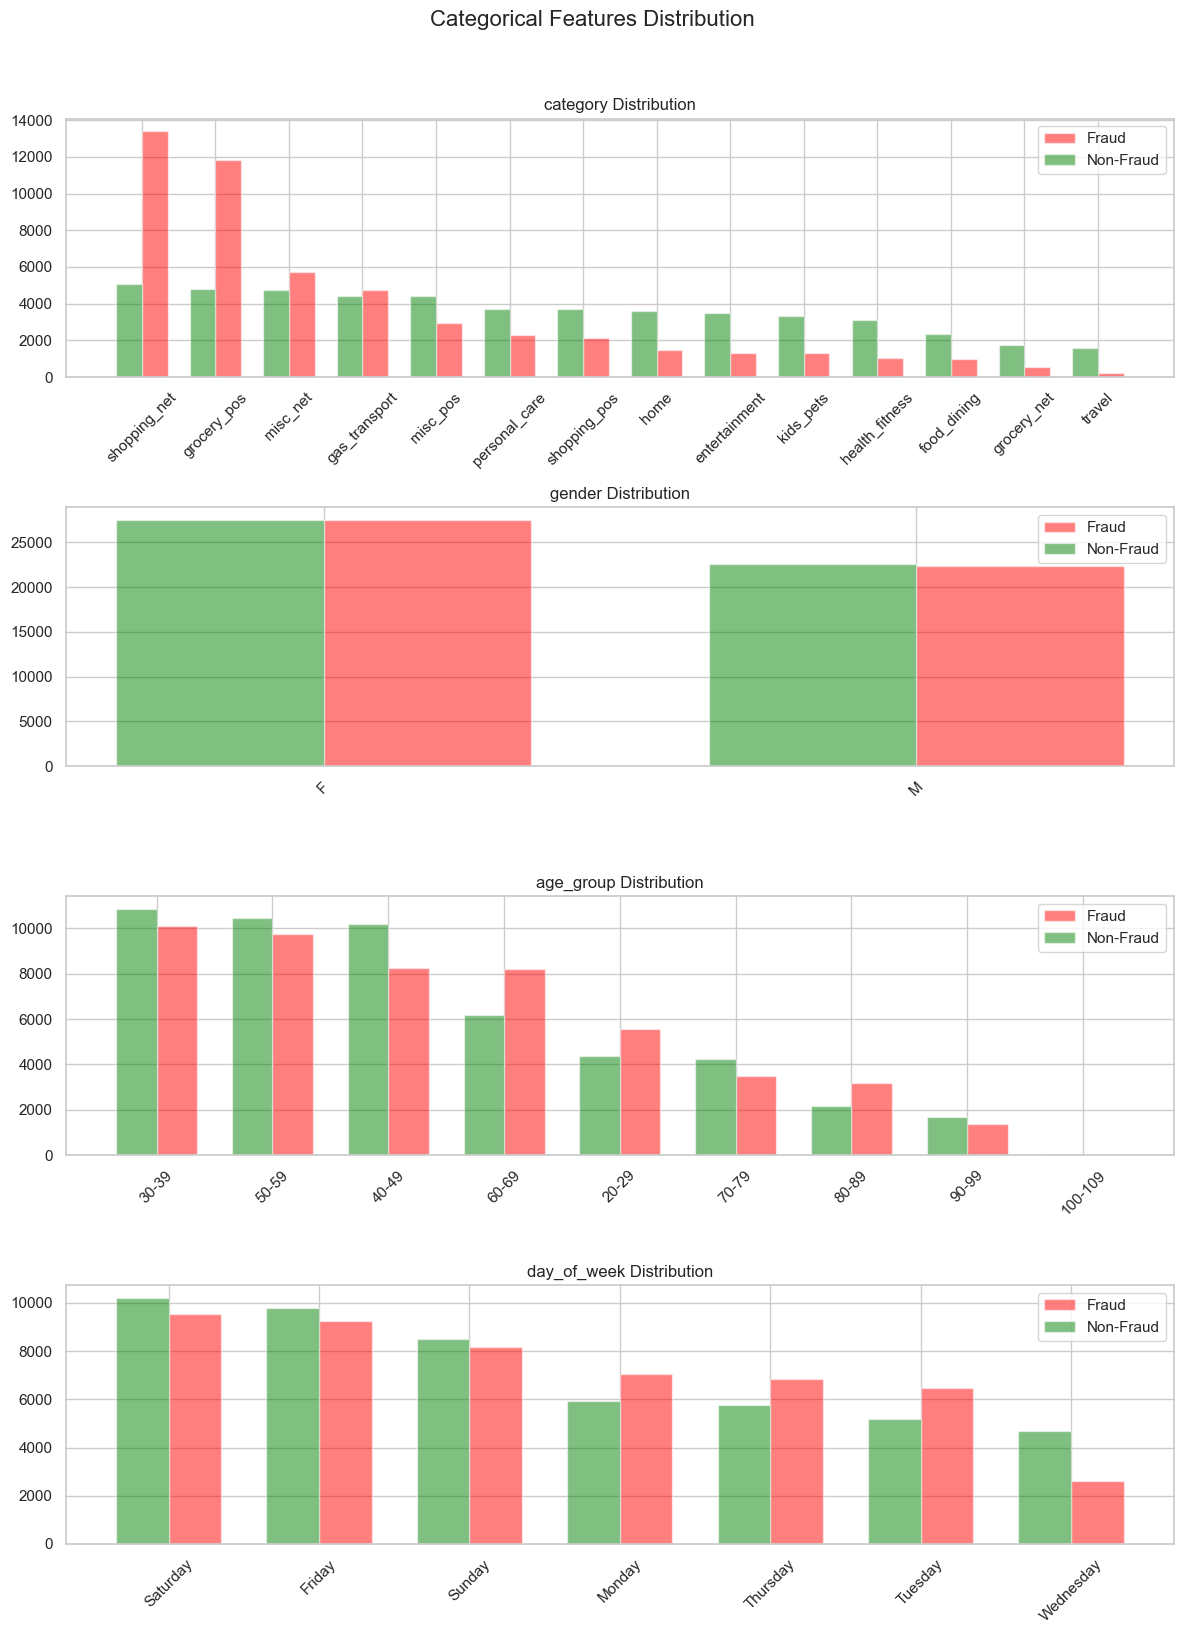

In [20]:
plot_categorical_distributions(data_train)

### Relationship between features and fraud

In [21]:
def plot_feature_importance(data, sample_size=100000):
    """
    Create visualisations to understand the relationship between features and fraud.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The dataset containing features and 'is_fraud' column
    sample_size : int, optional (default=100000)
        Number of rows to sample for visualisation to handle large datasets
    """
    # Sample data for visualisation
    data_sample = data.sample(n=min(sample_size, len(data)), random_state=42)
    
    # Select important numerical features for analysis
    important_features = ['amt', 'dist', 'hour']
    
    # Create plots
    fig, axes = plt.subplots(len(important_features), 1, figsize=(12, 4*len(important_features)))
    fig.suptitle('Key Feature Analysis for Fraud Detection', y=1.02, fontsize=16)
    
    for idx, feature in enumerate(important_features):
        ax = axes[idx] if len(important_features) > 1 else axes
        
        # Create KDE plot
        sns.kdeplot(x=feature, 
                    data=data_sample,
                    hue='is_fraud',
                    common_norm=False,
                    ax=ax)
        
        ax.set_title(f'{feature} Distribution in Fraudulent vs Non-Fraudulent Transactions')
        ax.legend(title='Transaction Type', labels=['Legitimate', 'Fraudulent'])
    
    plt.tight_layout()
    plt.show()

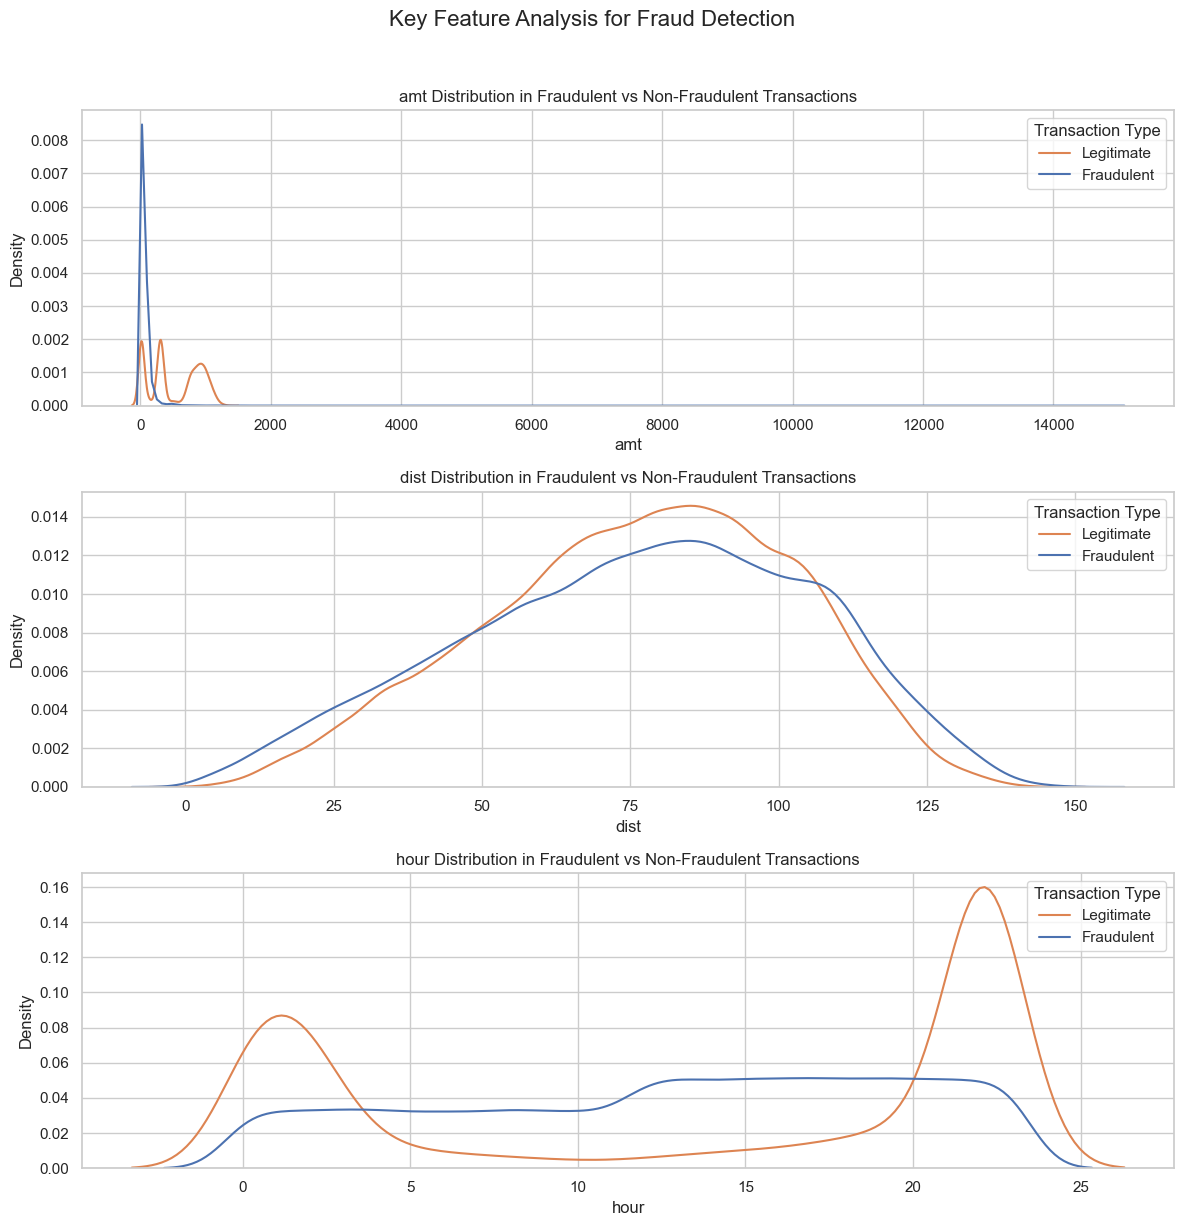

In [22]:
plot_feature_importance(data_train)

### Key Features Pairs

In [23]:
def plot_feature_pairs(data, sample_size=10000, key_features = ['amt', 'dist', 'hour', 'is_fraud']):
    # Sample a smaller subset due to the computational intensity of pair plots
    data_sample = data.sample(n=min(sample_size, len(data)), random_state=42)
    
    # Create pair plots
    plt.figure(figsize=(12, 10))
    sns.pairplot(data_sample[key_features], hue='is_fraud', diag_kind='kde', hue_order=[1, 0])
    plt.suptitle('Relationships Between Key Features', y=1.02)
    plt.show()

<Figure size 1200x1000 with 0 Axes>

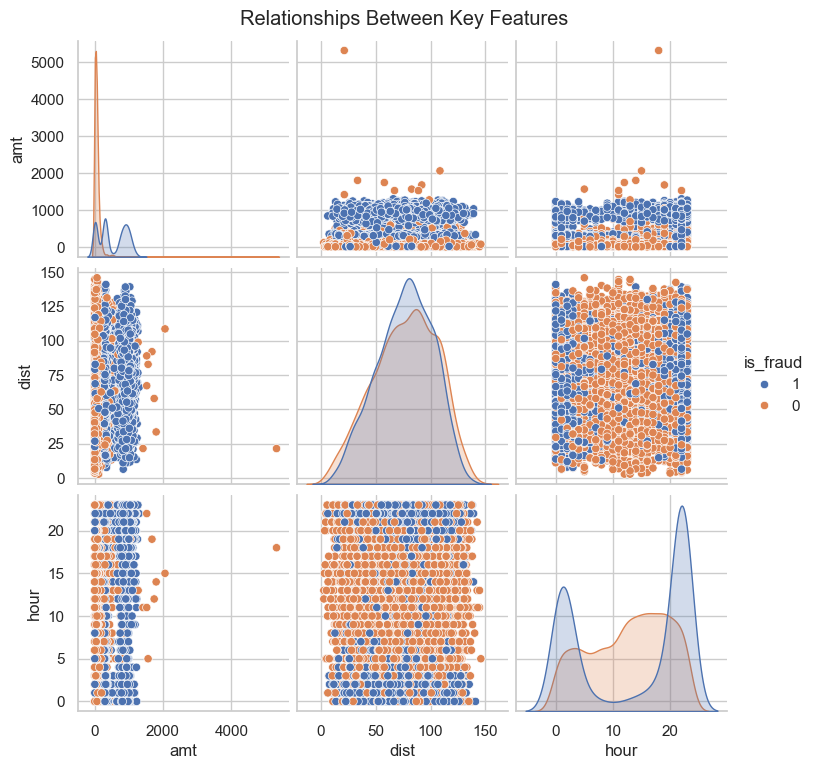

In [24]:
plot_feature_pairs(data_train)

### Time Patterns

In [25]:
def plot_time_patterns(data):
    # Group by hour and calculate fraud rate
    hourly_fraud = data.groupby('hour')['is_fraud'].mean().reset_index()
    
    # Plot fraud rate by hour
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='hour', y='is_fraud', data=hourly_fraud, marker='o')
    plt.title('Fraud Rate by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Fraud Rate')
    plt.xticks(range(0, 24))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

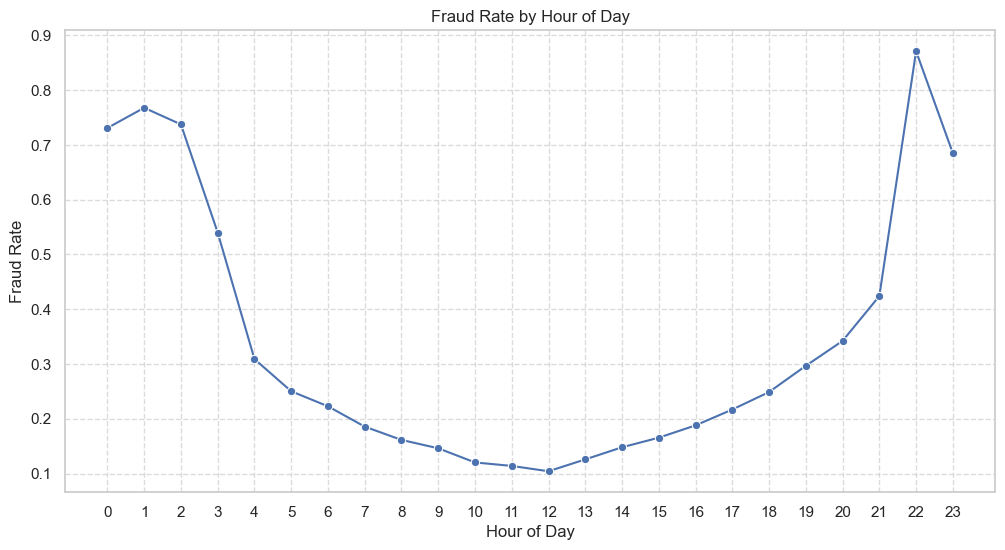

In [26]:
plot_time_patterns(data_train)

### Geographical Distribution

In [27]:
def plot_geo_distribution(data, sample_size=100000):
    # Sample data
    data_sample = data.sample(n=min(sample_size, len(data)), random_state=42)
    
    # Create scatter plot
    plt.figure(figsize=(12, 10))
    plt.scatter(data_sample[data_sample['is_fraud']==0]['long'], 
                data_sample[data_sample['is_fraud']==0]['lat'], 
                alpha=0.5, s=1, label='Legitimate')
    plt.scatter(data_sample[data_sample['is_fraud']==1]['long'], 
                data_sample[data_sample['is_fraud']==1]['lat'], 
                alpha=0.5, s=5, color='red', label='Fraudulent')
    plt.title('Geographical Distribution of Transactions')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

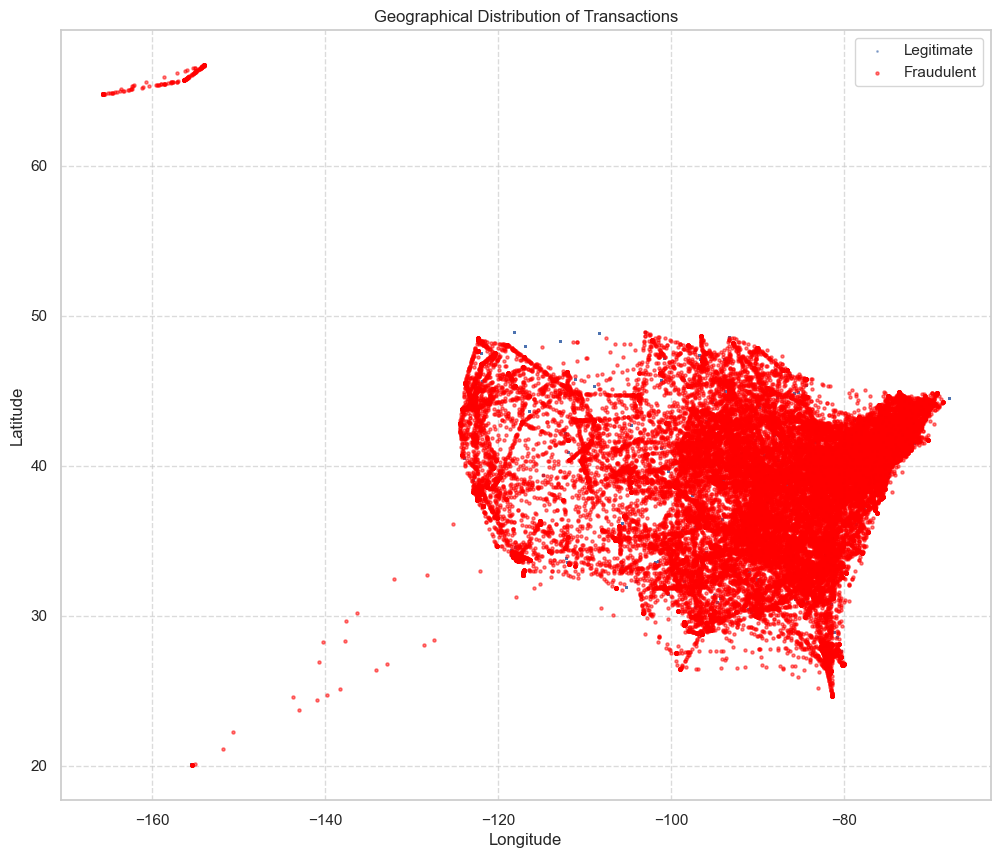

In [28]:
plot_geo_distribution(data_train)

## Import pre-trained models and get predictions

In [29]:
models = utils.load_models()


===== MODEL METADATA =====
[INFO] Found [2] models in `architectures/`

=== Model: `model_1_Siddhartha_CNN_acc99` ===
Input shape: (None, 15, 1)
Output shape: (None, 1)
Number of layers: 9
Total parameters: 60,065
File size: 0.00 MB
Last modified: Mon Apr 21 07:15:35 2025

--------------------------------------------------

=== Model: `model_2_Ibtissam_LSTM_acc98` ===
Input shape: (None, 15)
Output shape: (None, 1)
Number of layers: 6
Total parameters: 33,502
File size: 0.00 MB
Last modified: Sat Apr 26 05:08:26 2025

--------------------------------------------------


In [30]:
if MAKE_PREDICTIONS:
    predictions = pd.DataFrame()
    
    for model_name, model in models.items():
        y_predict = model.predict(X_test)
        predictions[model_name] = y_predict.flatten()

        # Save predictions
        utils.save_predictions(model_name, y_predict)
else:
    predictions = pd.read_csv(os.path.join(DATA_PATH, 'predictions.csv'))

In [31]:
for model_name, y_predict in predictions.items():
    print(f'Model `{model_name}` metrics: ')
    display(utils.get_model_metrics_df(y_test, y_predict))

Model `model_1_Siddhartha_CNN_acc99` metrics: 


Metric     Value
0             Accuracy  0.986616
1        ROC AUC Score  0.994009
2  Precision (Class 0)  0.999680
3     Recall (Class 0)  0.986880
4   F1-Score (Class 0)  0.993239
5  Precision (Class 1)  0.213365
6     Recall (Class 1)  0.918415
7   F1-Score (Class 1)  0.346282

Model `model_2_Ibtissam_LSTM_acc98` metrics: 


Metric     Value
0             Accuracy  0.975781
1        ROC AUC Score  0.971162
2  Precision (Class 0)  0.999266
3     Recall (Class 0)  0.976404
4   F1-Score (Class 0)  0.987703
5  Precision (Class 1)  0.118028
6     Recall (Class 1)  0.814918
7   F1-Score (Class 1)  0.206193

## Extract global attributes

In [32]:
# All features
features = data_test.columns.drop('is_fraud').to_list()

# Collect all categorical features
categorical_features = list(data_test.select_dtypes(include=['bool', 'category', 'object']).columns)
categorical_names = {features.index(col): transformations[col].classes_.tolist() for col in categorical_features}
categorical_idx = list(categorical_names.keys())

# Collect all methods and metrics names
methods_list = ['SHAP', 'LIME', 'Anchors']
metrics_list = ['Faithfulness', 'Monotonicity', 'Completeness']

In [33]:
# Create a DataFrame to track misclassifications
misclassified = pd.DataFrame(index=predictions.index)

# Process each model
for model_name in predictions.columns:
    # Convert probabilities to predictions
    preds = np.round(predictions[model_name]).astype(int)
    # Mark misclassifications
    misclassified[model_name] = (preds != y_test)
    # Show statistics
    print(f"`{model_name}` misclassifications: [{misclassified[model_name].sum()}/{len(data_test)}]")

# Find samples that ALL models misclassified
mutually_misclassified_indices = predictions.index[misclassified.all(axis=1)].tolist()

# Print some statistics
print(f"Mutually misclassified samples: [{len(mutually_misclassified_indices)}/{len(data_test)}]")

`model_1_Siddhartha_CNN_acc99` misclassifications: [7438/555719]
`model_2_Ibtissam_LSTM_acc98` misclassifications: [13459/555719]
Mutually misclassified samples: [2298/555719]


## Choose model to analyse locally (explain single specific prediction)

In [187]:
model_name = list(models.keys())[0]
y_predict = predictions[model_name]
y_predict_binary = np.round(y_predict).astype(int).squeeze()
model = models[model_name]
postfix_indicator = f"_of_{model_name.split('_')[3]}"

# Collect all misclassified entries (For later explaination on why the model predicted them incorrectly)
misclassified_indices = np.where(y_test != y_predict_binary)[0]
print(f"Model: `{model_name}` | Misclassified samples: [{len(misclassified_indices)}/{len(data_test)}]")

Model: `model_1_Siddhartha_CNN_acc99` | Misclassified samples: [7438/555719]


## XAI Methods

### SHAP

#### SHapley Additive exPlanations (SHAP) [Paper, 2017](https://arxiv.org/abs/1705.07874)

> *A unified approach that applies game theory to explain individual predictions of any machine learning model, with theoretical guarantees of fairness and consistency*

##### SHAP Process in Fraud Detection:
1. **Frame as a Game:** Treat feature values as "players" in a cooperative game where the "payout" is the prediction.
2. **Calculate Contributions:** Determine how each feature contributes by measuring its effect across all possible feature combinations.
3. **Assign Values:** Compute Shapley values representing each feature's contribution to moving from a baseline prediction to the actual prediction.
4. **Visualize:** Present these values as force plots, waterfall charts, or dependency plots showing how features push predictions toward or away from fraud.

##### Technical Implementation:
SHAP assigns each feature an importance value for a particular prediction through a clever algorithm that:
- Calculates expectations when a feature is "present" versus "absent"
- Averages these differences across all possible feature combinations
- Ensures the sum of all feature contributions equals the difference between baseline and actual prediction

##### Key Approaches:
* **KernelExplainer:** Model-agnostic but computationally intensive for complex models.

SHAP uniquely balances local accuracy (matching model behavior), consistency (features with stronger effects get higher attribution), and the "missingness" property (missing features are properly handled). This makes it particularly valuable for credit card fraud detection, where reliable attributions build trust in high-stakes decisions.

- [SHAP Documentations](https://shap.readthedocs.io/en/latest/)
- [SHAP Code Tutorial from original paper authors](https://github.com/slundberg/shap)

#### Implementation

Using `KernelExplainer`

We need to create a `background` dataset: This is because deep neural networks are complex and non-linear, so they require reference points (background samples) to understand how the model normally behaves and accurately calculate feature importance.

Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly `1/sqrt(N)` for `N` background data samples.

So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [173]:
def get_shap_explanation(model, sample, background_size=100, verbose='auto'):
    """Get SHAP explanation for an sample"""
    sample = transformations['scaler'].inverse_transform(sample)
    background = shap.utils.sample(transformations['scaler'].inverse_transform(X_train), background_size)
    
    # Create a wrapper function for prediction
    def model_predict_fn(x):
        x_scaled = transformations['scaler'].transform(x)
        return model.predict(x_scaled, verbose=verbose).flatten()
    
    # Use `KernelExplainer` which is model-agnostic
    explainer = shap.KernelExplainer(model_predict_fn, background, feature_names=features)
    
    # Get SHAP values
    shap_explainer = explainer(sample, silent=True)
    
    # Return dict of feature:importance pairs
    shap_dict = {feature: value for feature, value in zip(shap_explainer.feature_names, shap_explainer.values.squeeze())}
    return shap_dict, shap_explainer

#### Get SHAP values

In [174]:
# Try to explain sample at `idx`
idx = mutually_misclassified_indices[0]

print(f'Considering Index: [{idx}]')
postfix_indicator = postfix_indicator[:7] + f"_at_{idx}"

sample = X_test[[idx]]

background_size = 100
shap_dict, shap_explainer = get_shap_explanation(model, sample, background_size)

pd.DataFrame({
    'feature': shap_explainer.feature_names,
    'shap_abs': shap_explainer.values.squeeze()

}).set_index('feature').sort_values('shap_abs', ascending=False, key=abs)

Considering Index: [1044]
6494/6494 [==============================] - 30s 5ms/step


shap_abs
feature              
amt          0.579851
category    -0.101582
hour        -0.019837
gender       0.012475
age_group   -0.011093
day_of_week -0.008132
city_pop    -0.008025
month       -0.003862
merchant    -0.003251
lat         -0.002960
age          0.002818
merch_long   0.002630
merch_lat    0.002078
long        -0.001726
dist         0.000000

In [175]:
SAVE_FIGURES = True

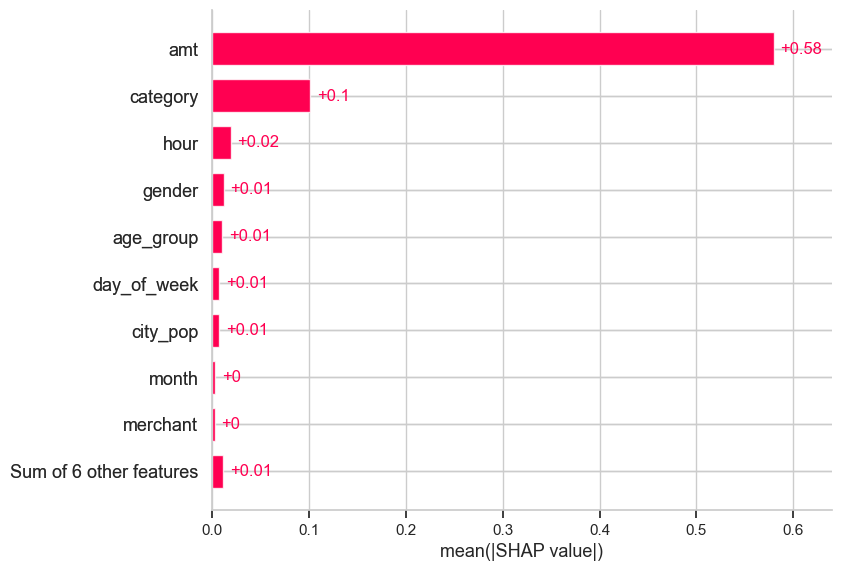

In [176]:
shap.plots.bar(shap_explainer, show=False)
plt.savefig(os.path.join(VISUALISATION_PATH, f'shap_bar_plot{postfix_indicator}.png'), dpi=600, bbox_inches='tight') if SAVE_FIGURES else None
plt.show()

#### Waterfall Plot

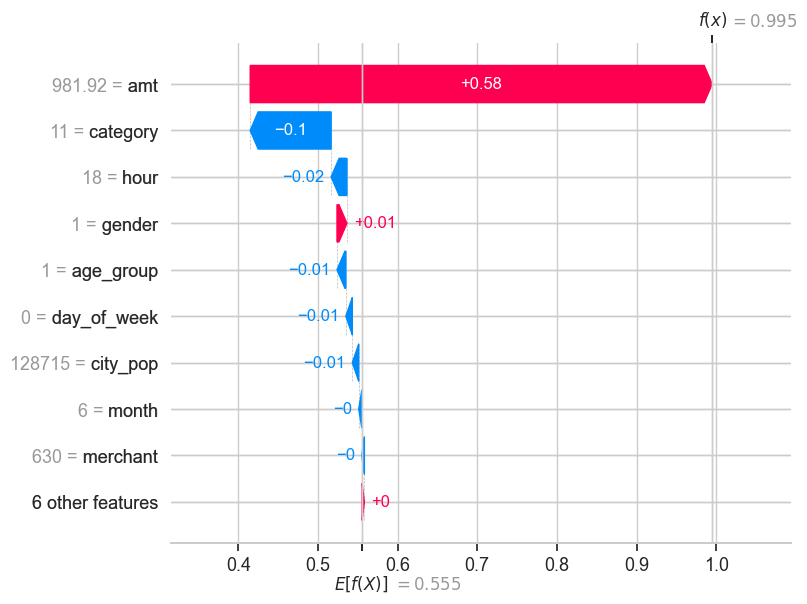

In [177]:
shap.plots.waterfall(shap_explainer[0], show=False)
plt.savefig(os.path.join(VISUALISATION_PATH, f'shap_waterfall_plot{postfix_indicator}.png'), dpi=600, bbox_inches='tight') if SAVE_FIGURES else None
plt.show()

#### How to Interpret - SHAP Waterfall Plot

You can visualize the SHAP values for an instance of interest. For an instance of interest, you can see the SHAP values and their contribution to the prediction for that instance.

On the left side of the feature names are the specific feature values for the instance of interest

#### Force Plot

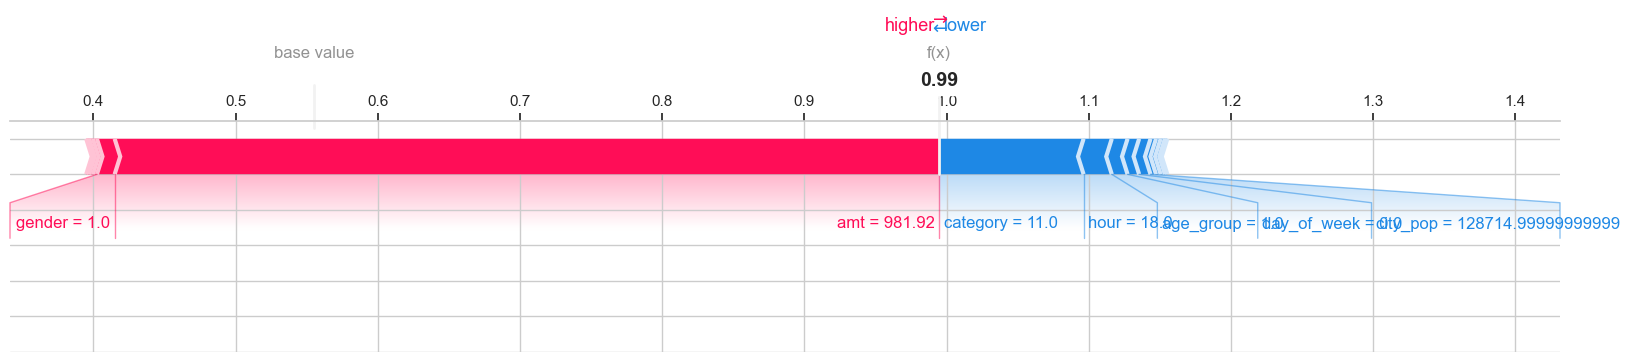

In [178]:
# shap.initjs()
shap.force_plot(shap_explainer, matplotlib=True, show=False)
plt.savefig(os.path.join(VISUALISATION_PATH, f'shap_force_plot{postfix_indicator}.png'), dpi=600, bbox_inches='tight') if SAVE_FIGURES else None
plt.show()

#### How to Interpret - SHAP Force Plot

SHAP force plots show how each feature pushes a transaction toward or away from being classified as fraud:

- **Red arrows** (pointing right) push toward fraud
- **Blue arrows** (pointing left) push toward legitimate
- **Arrow size** shows influence strength
- **Base value** is the model's average prediction
- **Final score** appears on the right

The plot lists each feature with its actual value so you can quickly see which transaction characteristics are influencing the fraud decision most strongly.

Force plots help fraud analysts immediately spot why a transaction was flagged, making review faster and more accurate.


### LIME

#### Local Interpretable Model-Agnostic Explanations (LIME) [Paper, 2016](https://arxiv.org/abs/1602.04938)


> *Interpretable models that are used to explain individual predictions of black box machine learning models (for credit card fraud detection in this project)*

##### LIME Process in Fraud Detection:
1. **Select:** Choose a transaction (e.g., a potential fraud case).
2. **Perturb:** Create variations by slightly altering its features.
3. **Generate:** Build a dataset of these perturbed transactions with their fraud predictions.
4. **Train:** Fit an easy-to-interpret model on this new dataset, giving more weight to samples similar to the original transaction.
5. **Interpret:** Use the simple model to show which features drove the fraud prediction.

##### Technical Implementation:
* **Numerical Features:** Compute statistics (mean, std) and bin values (e.g., into quartiles).
* **Categorical Features:** Calculate the frequency of each category.

##### Key Parameter:
* **Kernel Width:**  
  - **Small width:** Only very similar transactions influence the explanation (high precision).  
  - **Large width:** More diverse transactions are included (wider coverage).

LIME helps make fraud detection more transparent by clarifying why a specific transaction was flagged as suspicious.

[LIME Code Tutorial from original paper authors](https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20continuous%20and%20categorical%20features.html)

#### Example

##### **Original Transaction Instance**

```python
transaction = {
    'amt': 1850.75,        # Transaction amount
    'age': 27,             # Customer age
    'dist': 792.3,         # Distance from home location
    'F': 1,                # Female gender
    'M': 0,                # Male gender
    '20 to 30': 1,         # Age bracket
    'AK': 1,               # State (Alaska)
    'shopping_pos': 1,     # Transaction category
}
```

##### **Step 1: Generate Perturbations**

Creating slightly modified versions (perturbations) of the original transaction by adding small random noise based on the feature's statistics (mean and standard deviation):

```python
perturbed_transactions = [
    {    # Perturbed 1 (`AK` changed, `CA` added)
        'amt': 1750.25, 'age': 27, 'dist': 792.3, 
        'F': 1, 'M': 0, '20 to 30': 1, 
        'AK': 0, 'CA': 1, 'shopping_pos': 1
    },
    {    # Perturbed 2 (`shopping_pos` `changed`, `grocery_pos` added)
        'amt': 1850.75, 'age': 27, 'dist': 792.3,
        'F': 1, 'M': 0, '20 to 30': 1, 
        'AK': 1, 'shopping_pos': 0, 'grocery_pos': 1
    },
    {    # Perturbed 3 (`distance`, `age` changed)
        'amt': 1850.75, 'age': 42, 'dist': 156.7,
        'F': 1, 'M': 0, '20 to 30': 0, '40 to 50': 1, 
        'AK': 1, 'shopping_pos': 1
    },
    # ... many more variations
]

# Get predictions from the black box model
predictions = [
    0.35,  # Transaction 1 - lower probability of fraud
    0.42,  # Transaction 2
    0.28,  # Transaction 3
    # ... and so on
]
```

##### **Step 2: Analyze Feature Distributions**
LIME analyzes the distribution of values in the perturbed samples:
```python
# Feature statistics for discretization
amt_stats = {
    'mean': 1523.45,
    'std': 342.87,
    'thresholds': [-0.60, -0.46, -0.32, -0.18, 0.04, 0.26, 0.48]  # normalized
}

dist_stats = {
    'mean': 457.23,
    'std': 389.52,
    'thresholds': [-0.82, -0.51, -0.20, 0.09, 0.41, 0.75, 1.08]  # normalized
}

# ...

For binary categorical features thresholds, LIME typically uses: The percent point function (ppf) of the normal distribution + A small adjustment factor (typically around 0.4 to 0.6) + A small shift constant (often between -0.1 and 0.1)

# Categorical feature analysis
AK_stats = {
    'frequency': 0.03,
    'ppf_calculation': -1.88,  # (ppf(0.03) ≈ -1.88) Inverse of standard normal CDF at 0.03 
    'threshold': -0.06,  # -1.88 * 0.03 - 0.00 ≈ -0.06 (Low adjustment factor (0.03) used due to feature rarity; no shift needed)
}

shopping_pos_stats = {
    'frequency': 0.15,
    'ppf_calculation': -1.04, # (ppf(0.15) ≈ -1.04) Inverse of standard normal CDF at 0.15
    'threshold': -0.33,  # -1.04 * 0.3 + 0.0 ≈ -0.312 (Medium adjustment factor (0.3); no shift applied as base calculation was close to desired scale)
}

grocery_pos_stats = {
    'frequency': 0.22,
    'ppf_calculation': -0.77, # (ppf(0.22) ≈ -0.77) Inverse of standard normal CDF at 0.22
    'threshold': -0.43,  # -0.77 * 0.45 - 0.08 ≈ -0.427 (Medium-high adjustment (0.45) with small negative shift to maintain consistent relationship with `shopping_pos`)
}
```

##### **Step 3: Discretize Continuous Features**
LIME converts continuous features into binary features using thresholds:
```python
# Original transaction (normalized)
normalized_transaction = {
    'amt': -0.51,  # (1850.75 - mean) / std
    'dist': 0.39,  # (792.3 - mean) / std
    # ...other features
}

# Binary features after discretization
binary_features = {
    '-0.60 < amt <= -0.46': 1,  # True
    '0.09 < dist <= 0.41': 1,   # True
    'AK <= -0.06': 1,                    # True
    'F <= 0.91': 1,                     # True
    'shopping_pos <= -0.33': 1,          # True
    # ...
    'amt <= -0.60': 0, 
    '-0.60 < amt <= -0.46': 0, 
    '-0.46 < amt <= -0.32': 0,
    '-0.32 < amt <= -0.18': 0,
    '-0.18 < amt <= 0.04': 0, 
    '0.04 < amt <= 0.26': 0,
    '0.26 < amt <= 0.48': 0,
    'amt > 0.48': 0
    # ... many more binary features (All other features will be 0)
}
```

##### **Step 4: Apply Kernel Weighting**

LIME uses this kernel weighting formula: 

$$\pi_x(z) = \exp\left(-\frac{D(x, z)^2}{\sigma^2}\right)$$

Where:
- $D(x, z)$ is the distance between original transaction $x$ and perturbed sample $z$ (binary distance will be count of features that differ)
- $\sigma$ controls how quickly weight decays with distance

**Perturbed 1**: (`AK` changed, `CA` added)
$$\pi_x(z_1) = \exp\left(-\frac{2^2}{1.5^2}\right) = \exp(-1.78) = 0.17$$

**Perturbed 2**: (`shopping_pos` changed, `grocery_pos` added)
$$\pi_x(z_2) = \exp\left(-\frac{2^2}{1.5^2}\right) = \exp(-1.78) = 0.17$$

**Perturbed 3**: (`distance` bin, `age` bracket changed, new `age` bracket added)
$$\pi_x(z_3) = \exp\left(-\frac{3^2}{1.5^2}\right) = \exp(-4) = 0.02$$


##### **Step 5: Train Local Interpretable Model**

LIME fits a weighted linear model to approximate the black box model locally:

$$g(z) = \beta_0 + \beta_1 z_1 + \beta_2 z_2 + \cdots + \beta_d z_d$$

**Loss Function** (Minimize the weighted squared error):

$$\min_{\beta_0, \beta} \sum_{i=1}^{n} \pi_x(z_i) \left( f(z_i) - \big(\beta_0 + \beta^T z_i\big) \right)^2$$

Where $f(z_i)$ is the black box prediction for perturbed transaction $z_i$.

##### **Step 6: Interpret Feature Contributions**

The coefficients (β) of the linear model show each feature's contribution:

| **Feature**   | **Contribution** | **Interpretation**            |
|---------------|:----------------:|-------------------------------|
| **AK <= -0.06**        |      **+0.73**   | **Strongly indicates fraud**  |
| **-0.60 < amt <= -0.46**       |      **+0.31**   | Moderately indicates fraud    |
| **0.09 < dist <= 0.41**      |      **+0.26**   | Moderately indicates fraud    |
| shopping_pos <= -0.33  |        +0.12     | Slightly indicates fraud      |
| -0.79 < age <= -0.11           |        -0.08     | Slightly indicates legitimate |
| F <= 0.91             |        -0.04     | Minimal impact                |

#### Implementation

In [179]:
def get_lime_explanation(model, sample, kernel_width=np.sqrt(len(features))*0.75, new_instance=False, verbose='auto'):
    """Get LIME explanation for an sample"""
    sample = transformations['scaler'].inverse_transform(sample).squeeze()
    
    # Create LIME explainer
    global lime_tabular_explainer
    if new_instance:
        lime_tabular_explainer = lime_tabular.LimeTabularExplainer(
            training_data=transformations['scaler'].inverse_transform(X_train),
            feature_names=features,
            categorical_features=categorical_idx,
            categorical_names=categorical_names,
            kernel_width=kernel_width,
            class_names=['non-fraud', 'fraud'],
            verbose=verbose
        )
    
    # Create a prediction function that returns probabilities for BOTH classes
    def model_predict_fn(x):
        x_scaled = transformations['scaler'].transform(x)
        preds = model.predict(x_scaled, verbose=verbose)
        return np.hstack((1-preds, preds))
    
    # Get explanation
    lime_explainer = lime_tabular_explainer.explain_instance(
        sample, 
        model_predict_fn,
        num_features=len(features)
    )
    
    # Extract feature importances from LIME explanation
    lime_dict = {features[idx]: value for idx, value in dict(lime_explainer.as_map()[1]).items()}
    
    return lime_dict, lime_explainer

In [180]:
# Define some characteristics of the dataset
kernel_width = np.sqrt(len(features)) * 0.75

# Only need to perform the perturbations once with the train set
lime_tabular_explainer = lime_tabular.LimeTabularExplainer(
    training_data=transformations['scaler'].inverse_transform(X_train),
    feature_names=features,
    categorical_features=categorical_idx,
    categorical_names=categorical_names,
    kernel_width=kernel_width,
    class_names=['non-fraud', 'fraud'],
)

Considering Index: [1044]
157/157 [==============================] - 1s 4ms/step


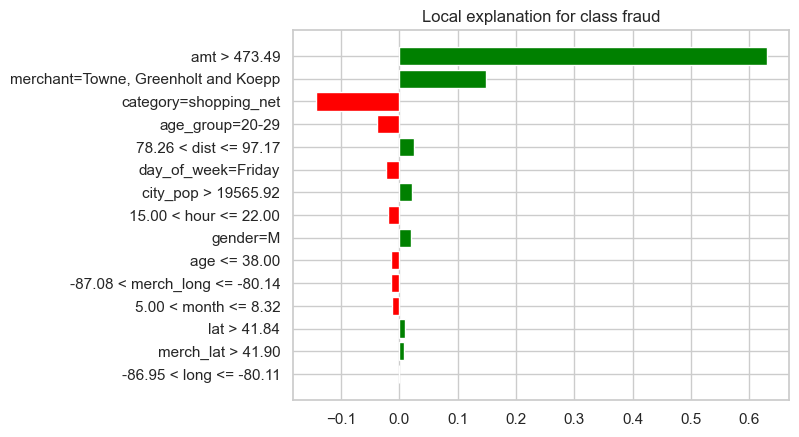

merchant      category     amt gender      lat  \
1044  Towne, Greenholt and Koepp  shopping_net  981.92      M  43.2326   

         long  city_pop  merch_lat  merch_long  age age_group       dist  \
1044 -86.2492    128715  43.849101  -85.560458   29     20-29  88.210686   

      hour day_of_week  month  is_fraud  
1044    18      Friday      6         0

In [181]:
# Try to explain sample at `idx`
idx = mutually_misclassified_indices[0]

print(f'Considering Index: [{idx}]')
postfix_indicator = postfix_indicator[:7] + f"_at_{idx}"

sample = X_test[[idx]]

lime_dict, lime_explainer = get_lime_explanation(model, sample, kernel_width)

lime_explainer.as_pyplot_figure()
plt.savefig(os.path.join(VISUALISATION_PATH, f'lime_explain_plot{postfix_indicator}.png'), dpi=600, bbox_inches='tight') if SAVE_FIGURES else None
plt.show()

lime_explainer.show_in_notebook()
lime_explainer.save_to_file(os.path.join(VISUALISATION_PATH, f'lime_notebook{postfix_indicator}.html')) if SAVE_FIGURES else None

data_test.iloc[[idx]]

#### How to interpret LIME Visualisations

**Visual Guide:**
* **Left side**: Prediction probability is shown 
* **Blue bars (left)**: Features contributing to "legitimate" prediction
* **Orange bars (right)**: Features contributing to "fraudulent" prediction

**Tabular View:**
* Shows actual value for each feature
* Highlights contribution to each outcome (legitimate or fraudulent)

**Analysis Tips:**
Pay attention to which transaction characteristics most strongly influence the fraud determination. For example:
* Unusually large transaction amount
* Atypical merchant category
* Transaction occurring at unusual time

These insights help financial analysts understand why the model flagged specific transactions, improving both accuracy of manual reviews and overall model transparency.

### Anchors

#### High-Precision Model-Agnostic Explanations (Anchors) [Paper, 2018](https://ojs.aaai.org/index.php/AAAI/article/view/11491)

> *Anchors explain individual predictions with simple IF-THEN rules that capture key conditions behind a decision.*

##### **Anchors Process in Fraud Detection:**
1. **Generate Rule Candidates:** Propose simple rules that could explain a model's prediction.
2. **Select Best Anchor:** Identify the rule that best explains the specific transaction.
3. **Validate Precision:** Confirm the rule’s accuracy by testing it on similar cases.
4. **Refine with Search:** Improve the rule using an efficient search algorithm.

##### **Key Insights:**
* **Anchors are IF-THEN rules** that provide clear, high-precision explanations.
* They focus on **accuracy over coverage**: the rule is very reliable when it applies, even if it covers a small group.

[Anchors Code Tutorial from original paper authors](https://github.com/marcotcr/anchor/blob/master/notebooks/Anchor%20on%20tabular%20data.ipynb)

#### Implementation

In [182]:
def get_anchors_explanation(model, sample, batch_size=2000, new_instance=False, verbose='auto'):
    """Get Anchors explanation for an sample"""
    sample = transformations['scaler'].inverse_transform(sample)
    
    # Initialize Anchors explainer with the sample
    global anchor_tabular_explainer
    if new_instance:
        anchor_tabular_explainer = anchor_tabular.AnchorTabularExplainer(
            class_names=['non-fraud', 'fraud'],
            feature_names=features,
            train_data=transformations['scaler'].inverse_transform(X_train),
            categorical_names=categorical_names
        )

    # Create prediction function
    def model_predict_fn(x):
        x_scaled = transformations['scaler'].transform(x)
        preds = model.predict(x_scaled, verbose=verbose)
        return np.round(preds).astype(int).flatten()
    
    # Get explanation
    anchors_explainer = anchor_tabular_explainer.explain_instance(
        sample, 
        model_predict_fn,
        batch_size=batch_size
    )
    
    # Create a dictionary of feature binary importance based on rules
    anchor_dict = {feature: 1.0 if feature in [features[idx] for idx in anchors_explainer.features()] else 0.0 for feature in features}
    
    return anchor_dict, anchors_explainer

In [183]:
# Initialize Anchors explainer with the sample
anchor_tabular_explainer = anchor_tabular.AnchorTabularExplainer(
    train_data=transformations['scaler'].inverse_transform(X_train), 
    class_names=['non-fraud', 'fraud'],
    feature_names=features,
    categorical_names=categorical_names
)

In [184]:
# Try to explain sample at `idx`
idx = mutually_misclassified_indices[0]

print(f'Considering Index: [{idx}]')
postfix_indicator = postfix_indicator[:7] + f"_at_{idx}"

sample = X_test[[idx]]

# Explain with optimized parameters
print("Generating explanation (this may take some time)...")
anchor_dict, anchors_explainer = get_anchors_explanation(model, sample)

anchors_explainer.show_in_notebook()

if SAVE_FIGURES:
    with open(os.path.join(VISUALISATION_PATH, f'anchors_notebook{postfix_indicator}.html'), 'w', encoding='utf-8') as file:
        file.write(anchors_explainer.as_html())

Considering Index: [1044]
Generating explanation (this may take some time)...
1/1 [==============================] - 0s 48ms/step


In [185]:
# Print the anchors explanation
def print_anchors_explanation(anchors_explainer, sample, feature_names):
    """Anchors explanation printer"""
    sample = transformations['scaler'].inverse_transform(sample)
    
    print("\n" + "="*50)
    print(f"ANCHORS EXPLANATION")
    print("="*50)
    
    # Print the anchors rules
    if anchors_explainer.names():
        print("\nIF THESE CONDITIONS ARE MET:")
        for i, condition in enumerate(anchors_explainer.names(), 1):
            print(f"   {i}. {condition}")
        print(f"\nTHEN: Prediction is `{anchor_tabular_explainer.class_names[anchors_explainer.exp_map['prediction']]}`")
    else:
        print(f"No specific rules found. Prediction is `{anchor_tabular_explainer.class_names[anchors_explainer.exp_map['prediction']]}`")
    
    # Print metrics
    print("\nFEATURE VALUES FOR THIS INSTANCE:")
    print(f"  • Precision: {anchors_explainer.precision():.2f} → If these conditions are met, the prediction is the same {anchors_explainer.precision()*100:.1f}% of the time")
    print(f"  • Coverage: {anchors_explainer.coverage():.2f} → These conditions apply to {anchors_explainer.coverage()*100:.1f}% of similar instances")
    
    # Print important feature values 
    print("\nKey feature values:")
    for rule in anchors_explainer.names():
        for i, feat in enumerate(feature_names):
            if feat in rule:
                print(f"  • {feat}: {sample[0, i]}")
    
    print("="*50)

print_anchors_explanation(anchors_explainer, sample, features)

# Display the original data
print("\nOriginal data:")
data_test.iloc[[idx]]


ANCHORS EXPLANATION

IF THESE CONDITIONS ARE MET:
   1. amt > 473.49

THEN: Prediction is `fraud`

FEATURE VALUES FOR THIS INSTANCE:
  • Precision: 0.98 → If these conditions are met, the prediction is the same 97.7% of the time
  • Coverage: 0.26 → These conditions apply to 25.6% of similar instances

Key feature values:
  • amt: 981.92

Original data:


merchant      category     amt gender      lat  \
1044  Towne, Greenholt and Koepp  shopping_net  981.92      M  43.2326   

         long  city_pop  merch_lat  merch_long  age age_group       dist  \
1044 -86.2492    128715  43.849101  -85.560458   29     20-29  88.210686   

      hour day_of_week  month  is_fraud  
1044    18      Friday      6         0

#### How to Interpret

This rule means that if these conditions are met, the model’s fraud prediction is highly reliable. This explanation gives fraud analysts a clear rule they can understand and verify, rather than just a list of contributing factors.

## Evaluation and Metrics

### Select test cases

For each model, we need to select test cases using balanced stratified sampling based on that model's confidence.

In [450]:
def select_test_cases(pred_probs, sample_per_bin=10, include_edge=True, sample_testing=None, important_features = ['amt', 'dist', 'age', 'city_pop']):
    """
    Select test cases using balanced stratified sampling based on model confidence.
    
    Optionally, add "edge cases" with extreme values from important features.
    The DataFrame returned will have an additional column 'is_edge_case' flagging these samples.
    
    Parameters:
      - pred_probs: 1D array or list of prediction probabilities.
      - sample_per_bin: Number of samples to select per confidence bin.
      - sample_testing: If provided, randomly choose this many samples from the final selection (for quick testing).
      - include_edge: Boolean flag to include additional edge case indices.
      
    Returns:
      - sampled_indices: Array of selected indices.
      - df_samples: DataFrame with prediction probabilities, confidence bins, and an 'is_edge_case' flag.
    """
    # Create a DataFrame with prediction probabilities.
    df_samples = pd.DataFrame({'pred_prob': pred_probs})
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    labels = ['very_low', 'low', 'borderline', 'high', 'very_high']
    df_samples['confidence_bin'] = pd.cut(df_samples['pred_prob'], bins=bins, labels=labels, include_lowest=True)
    df_samples['index'] = np.arange(len(df_samples))
    
    # Balanced stratified sampling based on model confidence.
    sampled_indices = []
    for label in labels:
        bin_indices = df_samples[df_samples['confidence_bin'] == label]['index']
        if len(bin_indices) >= sample_per_bin:
            sampled = np.random.choice(bin_indices, size=sample_per_bin, replace=False)
        else:
            sampled = bin_indices.values  # if fewer available, take all
        sampled_indices.extend(sampled)
    sampled_indices = np.array(sampled_indices)
    
    # Edge cases: Unusual transactions with extreme feature values.
    if include_edge:
        df_samples['is_edge_case'] = False # Initially set is_edge_case flag to False.
        edge_cases = []
        for feature in important_features:
            # Get the column index in X_test via the global 'features' list.
            feature_idx = features.index(feature)
            
            # High extreme values: select the indices with the highest values.
            high_indices = np.argsort(X_test[:, feature_idx])[-sample_per_bin:].tolist()
            edge_cases.extend(high_indices)
            
            # Low extreme values:
            if feature in ['amt', 'dist']: # For these features, exclude zeros.
                valid_indices = np.where(X_test[:, feature_idx] > 0)[0]
                sorted_valid = valid_indices[np.argsort(X_test[valid_indices, feature_idx])]
                low_indices = sorted_valid[:sample_per_bin].tolist()
            else:
                low_indices = np.argsort(X_test[:, feature_idx])[:sample_per_bin].tolist()
            edge_cases.extend(low_indices)
        
        # Randomly select a fixed number of edge case samples.
        if len(edge_cases) >= sample_per_bin:
            additional_edge = np.random.choice(edge_cases, size=sample_per_bin, replace=False)
        else:
            additional_edge = edge_cases
            
        additional_edge = np.array(additional_edge)
        
        # Mark these edge case indices in the DataFrame.
        df_samples.loc[additional_edge, 'is_edge_case'] = True
        
        # Combine the stratified samples with the additional edge case samples.
        sampled_indices = np.unique(np.concatenate((sampled_indices, additional_edge)))
    
    # Optionally, for quick testing, randomly choose a subset.
    if sample_testing:
        sampled_indices = np.random.choice(sampled_indices, size=sample_testing, replace=False)
        
    df_samples = df_samples.set_index('index')
    return sampled_indices, df_samples.iloc[sampled_indices]

In [451]:
samples = pd.DataFrame()

if LOAD_METRICS and os.path.exists(os.path.join(DATA_PATH, 'stratified_samples.csv')):
    samples = pd.read_csv(os.path.join(DATA_PATH, 'stratified_samples.csv'), index_col=['model', 'index'])
else:
    for model_name, current_model in models.items():
        # Retrieve the sample.
        # Select test sample indices using balanced stratified sampling and include edge cases.
        pred_probs = predictions[model_name].values
        sampled_indices, model_samples = select_test_cases(
            pred_probs, 
            sample_per_bin=5,      # number per bin
            # sample_testing=3
        )
        model_samples['model'] = model_name
        print(f'[{len(sampled_indices)}] Stratified samples for `{model_name}` evaluation')
        samples = pd.concat([samples, model_samples])
                             
    samples = samples.reset_index().set_index(['model', 'index'])
    samples.to_csv(os.path.join(DATA_PATH, 'stratified_samples.csv'))
    
samples

pred_prob confidence_bin  is_edge_case
model                        index                                            
model_1_Siddhartha_CNN_acc99 15352   3.853730e-01            low         False
                             61009   7.074105e-01           high         False
                             99597   3.939763e-05       very_low         False
                             104701  2.052037e-09       very_low         False
                             105522  6.527454e-01           high          True
                             109706  9.999585e-01      very_high         False
                             116864  2.293766e-01            low         False
                             122920  3.038793e-06       very_low          True
                             138094  6.437703e-01           high         False
                             149049  7.381993e-01           high         False
                             160936  6.904898e-01           high         False
                             177648  5.616148e-01     borderline         False
                             188648  6.772678e-01           high         False
                             189565  9.259790e-01      very_high         False
                             190823  1.902570e-03       very_low          True
                             223930  9.998099e-01      very_high         False
                             246413  9.994241e-01      very_high         False
                             250349  4.666571e-01     borderline         False
                             252347  5.175728e-01     borderline         False
                             260449  2.198616e-06       very_low         False
                             265756  1.589119e-07       very_low          True
                             266823  2.990640e-01            low         False
                             280348  1.083679e-04       very_low         False
                             291148  3.178355e-01            low         False
                             321211  6.714932e-03       very_low          True
                             391495  9.975316e-01      very_high         False
                             436100  2.006648e-01            low         False
                             441064  4.259246e-01     borderline         False
                             507580  4.625595e-01     borderline         False
                             538262  3.346089e-07       very_low         False
model_2_Ibtissam_LSTM_acc98  2535    8.122980e-01      very_high         False
                             46770   9.022250e-01      very_high         False
                             54242   7.256410e-01           high         False
                             58581   2.246000e-03       very_low          True
                             59174   5.000000e-05       very_low         False
                             76535   3.365860e-01            low         False
                             106625  9.990000e-04       very_low          True
                             106753  4.136000e-02       very_low         False
                             142415  8.752770e-01      very_high         False
                             142481  7.545430e-01           high         False
                             175484  2.016700e-02       very_low          True
                             177306  2.236410e-01            low         False
                             180972  4.429500e-01     borderline         False
                             261997  6.283460e-01           high         False
                             266189  4.335490e-01     borderline         False
                             285370  2.400900e-01            low         False
                             285557  5.680340e-01     borderline         False
                             316526  2.080690e-01            low         False
                             325321  4.580600e-02       very_low         False
           

### Implement evaluation metrics

In [452]:
def measure_faithfulness(model, sample, explanation, baseline, verbose='auto'):
    """
    Measures how accurately an explanation reflects model behavior by removing features
    and observing prediction changes.
    
    Returns correlation between feature importance and prediction change.
    """
    # Get sample prediction
    sample_pred = model.predict(sample, verbose=verbose).squeeze()

    if len(set(explanation.values())) <= 1:
        return 0.0
    
    importance_scores = []
    prediction_changes = []
    
    for feature_name in features:
        # Get feature importance from explanation
        feat_importance = abs(explanation[feature_name])
        importance_scores.append(feat_importance)
        
        # Create modified sample with feature neutralized
        modified = sample.copy()
        feat_idx = features.index(feature_name)
        modified[0, feat_idx] = baseline[feat_idx]  # Replace with mean value
        
        # Get new prediction
        modified_pred = model.predict(modified, verbose=verbose).squeeze()
        
        # Calculate prediction change
        prediction_changes.append(abs(sample_pred - modified_pred))

    # Calculate correlation between importance and prediction change
    if len(importance_scores) > 1:
        faithfulness_score, _ = spearmanr(importance_scores, prediction_changes)
        return faithfulness_score
    else:
        return 0.0

def measure_monotonicity(model, sample, explanation, baseline, verbose='auto'):
    """
    Measures whether removing features in order of importance causes
    monotonically increasing changes in predictions.
    
    Returns: proportion of steps that maintain monotonicity
    """
    # Get sample prediction
    sample_pred = model.predict(sample, verbose=verbose).squeeze()
    
    # Rank features by absolute importance
    ranked_features = sorted(
        explanation.items(), 
        key=lambda x: abs(x[1]), 
        reverse=True
    )
    
    prediction_changes = []
    modified = sample.copy()
    
    for feature_name, _ in ranked_features:
        if feature_name in features:
            # Replace feature with mean value
            feat_idx = features.index(feature_name)
            modified[0, feat_idx] = baseline[feat_idx]
            
            # Get new prediction
            modified_pred = model.predict(modified, verbose=verbose).squeeze()
            
            # Record change
            prediction_changes.append(abs(sample_pred - modified_pred))
    
    # Calculate monotonicity - should increase or stay the same
    if len(prediction_changes) <= 1:
        return 1.0
    
    monotonicity_violations = sum(
        prediction_changes[i] > prediction_changes[i+1] for i in range(len(prediction_changes)-1)
    )
    
    monotonicity_score = 1.0 - (monotonicity_violations / (len(prediction_changes)-1))
    return monotonicity_score

def measure_completeness(model, sample, explanation, baseline, verbose='auto'):
    """
    Measures how much of the model's prediction is captured by the explanation.
    
    Higher values are better (1 = perfect completeness)
    """
    # Get original prediction
    sample_pred = model.predict(sample, verbose=verbose).squeeze()
    
    # Get baseline prediction (mean of training set predictions)
    baseline_pred = model.predict(np.expand_dims(baseline, axis=0), verbose=verbose).squeeze()
    
    # Sum feature contributions
    total_attribution = sum(explanation.values())
    
    # Calculate prediction difference (what should be explained)
    pred_diff = sample_pred - baseline_pred

    # Calculate completeness (higher is better, 1 means perfect)
    if abs(pred_diff) > 1e-10:
        completeness = 1 - (abs(pred_diff - total_attribution) / abs(pred_diff))
        return max(0.0, min(1.0, completeness))  # Ensure the value is clipped between 0 and 1
    else:
        return 1.0 if abs(total_attribution) < 1e-10 else 0.0

### Get all metrics across all models

**Steps:** 
1) Generate *SHAP* explanations
2) Generate *LIME* explanations
3) Generate *Anchors* explanations
4) Compute *Fidelity* metrics
5) Compute *Monotonicity* metrics
6) Compute *Incompletenes* metrics

In [453]:
# Prepare a nested dictionary to store metric results:
# xai_metrics = { model_name: { technique: {metric: list(values)} } }
xai_metrics = {}

if LOAD_METRICS and os.path.exists(os.path.join(DATA_PATH, 'xai_metrics.json')):
    xai_metrics = utils.loadJSON(os.path.join(DATA_PATH, 'xai_metrics.json'))
else:
    # Define a baseline vector (e.g., the mean of the training features in original scale)
    baseline = X_train.mean(axis=0)
    verbose = 0
    
    for model_name, current_model in models.items():
        print(f"Evaluating Model: {model_name}")
    
        # Retrieve the sample.
        sampled_indices = samples.loc[model_name].index
        print(f'[{len(sampled_indices)}] Stratified samples for `{model_name}` evaluation:')
        # display(samples)
        
        # Define number of inner update steps per sample.
        steps_per_instance = 6
        total_steps = len(sampled_indices) * steps_per_instance
        # Create a single progress bar that updates on one line.
        tqdm._instances.clear()
        pbar = tqdm(total=total_steps, leave=False)
        pbar.update(1)
        
        # Prepare dictionary to store metrics per technique for this model
        xai_metrics[model_name] = {method: {metric: [] for metric in metrics_list} for method in methods_list}
        
        for idx in sampled_indices:
            pbar.set_description(f"{model_name} | Retrieving sample at [{idx}]")
            sample = X_test[[idx]]
            
            # Step 1: Generate `SHAP` explanation.
            pbar.set_description(f"{model_name} | Generating `SHAP` explanation at [{idx}]")
            shap_dict, _ = get_shap_explanation(current_model, sample, verbose=verbose)
            pbar.update(1)
            
            # Step 2: Generate `LIME` explanation.
            pbar.set_description(f"{model_name} | Generating `LIME` explanation at [{idx}]")
            lime_dict, _ = get_lime_explanation(current_model, sample, verbose=verbose)
            pbar.update(1)
            
            # Step 3: Generate `Anchors` explanation.
            pbar.set_description(f"{model_name} | Generating `Anchors` explanation at [{idx}]")
            anchors_dict, _ = get_anchors_explanation(current_model, sample, verbose=verbose)
            pbar.update(1)
            
            # Step 4: Compute `Faithfulness` metrics.
            pbar.set_description(f"{model_name} | Computing `Faithfulness` metrics at [{idx}]")
            xai_metrics[model_name]['SHAP']['Faithfulness'].append(measure_faithfulness(current_model, sample, shap_dict, baseline, verbose=verbose))
            xai_metrics[model_name]['LIME']['Faithfulness'].append(measure_faithfulness(current_model, sample, lime_dict, baseline, verbose=verbose))
            xai_metrics[model_name]['Anchors']['Faithfulness'].append(measure_faithfulness(current_model, sample, anchors_dict, baseline, verbose=verbose))
            pbar.update(1)
            
            # Step 5: Compute `Monotonicity` metrics.
            pbar.set_description(f"{model_name} | Computing `Monotonicity` metrics at [{idx}]")
            xai_metrics[model_name]['SHAP']['Monotonicity'].append(measure_monotonicity(current_model, sample, shap_dict, baseline, verbose=verbose))
            xai_metrics[model_name]['LIME']['Monotonicity'].append(measure_monotonicity(current_model, sample, lime_dict, baseline, verbose=verbose))
            xai_metrics[model_name]['Anchors']['Monotonicity'].append(measure_monotonicity(current_model, sample, anchors_dict, baseline, verbose=verbose))
            pbar.update(1)
            
            # Step 6: Compute `Completeness` metrics.
            pbar.set_description(f"{model_name} | Computing `Completeness` metrics at [{idx}]")
            xai_metrics[model_name]['SHAP']['Completeness'].append(measure_completeness(current_model, sample, shap_dict, baseline, verbose=verbose))
            xai_metrics[model_name]['LIME']['Completeness'].append(measure_completeness(current_model, sample, lime_dict, baseline, verbose=verbose))
            xai_metrics[model_name]['Anchors']['Completeness'].append(measure_completeness(current_model, sample, anchors_dict, baseline, verbose=verbose))
            pbar.update(1)
            
        pbar.leave = True
        pbar.close()

    utils.saveJSON(xai_metrics, os.path.join(DATA_PATH, 'xai_metrics.json'))

### Summary Results

In [454]:
def get_summary_metrics(xai_metrics):
    try:
        summary_metrics = pd.DataFrame([
            {
                **{'mean': np.nanmean(values), 'std': np.nanstd(values), 
                   'min': np.nanmin(values), 'max': np.nanmax(values), 
                   'median': np.nanmedian(values)}
            }
            for model_name, methods_metrics in xai_metrics.items()
            for method, metrics in methods_metrics.items()
            for metric, values in metrics.items()
        ], index=pd.MultiIndex.from_tuples([
            (model_name, method, metric)
            for model_name, methods_metrics in xai_metrics.items()
            for method, metrics in methods_metrics.items()
            for metric, values in metrics.items()
        ], names=['Models', 'Methods', 'Metrics']))
    except: 
        print(f'Empty metrics')
        return None
    return summary_metrics

summary_metrics = get_summary_metrics(xai_metrics)
summary_metrics

mean       std  \
Models                       Methods Metrics                            
model_1_Siddhartha_CNN_acc99 SHAP    Faithfulness  0.442703  0.279769   
                                     Monotonicity  0.464286  0.141361   
                                     Completeness  0.208316  0.220163   
                             LIME    Faithfulness  0.253828  0.241427   
                                     Monotonicity  0.488095  0.141762   
                                     Completeness  0.295478  0.357816   
                             Anchors Faithfulness  0.314908  0.243676   
                                     Monotonicity  0.485714  0.165369   
                                     Completeness  0.032932  0.125092   
model_2_Ibtissam_LSTM_acc98  SHAP    Faithfulness  0.760513  0.127440   
                                     Monotonicity  0.428571  0.110657   
                                     Completeness  0.134167  0.182185   
                             LIME    Faithfulness  0.396310  0.164925   
                                     Monotonicity  0.445238  0.133864   
                                     Completeness  0.139081  0.290914   
                             Anchors Faithfulness  0.411920  0.213829   
                                     Monotonicity  0.469048  0.142480   
                                     Completeness  0.021546  0.087922   

                                                        min       max  \
Models                       Methods Metrics                            
model_1_Siddhartha_CNN_acc99 SHAP    Faithfulness -0.160858  0.782143   
                                     Monotonicity  0.214286  0.785714   
                                     Completeness  0.000000  0.632238   
                             LIME    Faithfulness -0.425000  0.653571   
                                     Monotonicity  0.214286  0.714286   
                                     Completeness  0.000000  0.967553   
                             Anchors Faithfulness -0.314038  0.662970   
                                     Monotonicity  0.071429  0.857143   
                                     Completeness  0.000000  0.577455   
model_2_Ibtissam_LSTM_acc98  SHAP    Faithfulness  0.485714  0.975000   
                                     Monotonicity  0.214286  0.642857   
                                     Completeness  0.000000  0.517583   
                             LIME    Faithfulness -0.025000  0.667857   
                                     Monotonicity  0.214286  0.714286   
                                     Completeness  0.000000  0.995677   
                             Anchors Faithfulness -0.220479  0.694365   
                                     Monotonicity  0.214286  0.785714   
                                     Completeness  0.000000  0.459074   

                                                     median  
Models                       Methods Metrics                 
model_1_Siddhartha_CNN_acc99 SHAP    Faithfulness  0.505357  
                                     Monotonicity  0.428571  
                                     Completeness  0.128901  
                             LIME    Faithfulness  0.266071  
                                     Monotonicity  0.500000  
                                     Completeness  0.023251  
                             Anchors Faithfulness  0.392954  
                                     Monotonicity  0.500000  
                                     Completeness  0.000000  
model_2_Ibtissam_LSTM_acc98  SHAP    Faithfulness  0.769249  
                                     Monotonicity  0.428571  
                                     Completeness  0.000000  
                             LIME    Faithfulness  0.382143  
                                     Monotonicity  0.428571  
                                     Completeness  0.000000  
                             Anchors Faithfulness  0.443467  
                 

In [455]:
# Mean values of each XAI method across all metrics
summary_metrics.pivot_table(values='mean', index='Methods', columns='Metrics')

Metrics  Completeness  Faithfulness  Monotonicity
Methods                                          
Anchors      0.027239      0.363414      0.477381
LIME         0.217280      0.325069      0.466667
SHAP         0.171241      0.601608      0.446429

### Filter Metrics based on `edge cases`/`confidence bins`

In [456]:
def filter_metrics(samples, xai_metrics, confidence_bins=None, is_edge_case=None):
    """
    Filter XAI metrics based on edge cases and/or confidence bins.
    
    Args:
        samples (pd.DataFrame): DataFrame containing sample information
        xai_metrics (dict): Dictionary of XAI metrics
        model_name (str): Name of the considering model
        confidence_bins (list, optional): List of confidence bin values to filter
        
    Returns:
        dict: Filtered metrics dictionary
    """
    global filtered_indices, values, mask
    
    # Validate inputs
    required_cols = ['confidence_bin', 'is_edge_case']
    if not all(col in samples.columns for col in required_cols):
        raise ValueError(f"Samples DataFrame must contain columns: {required_cols}")
        
    # Create edge case mask
    if is_edge_case != None:
        mask = samples['is_edge_case'] == is_edge_case
    else:
        mask = samples['is_edge_case'] != None

    # Add confidence bin filter if specified
    if confidence_bins is not None:
        conf_mask = samples['confidence_bin'].isin(confidence_bins)
        mask = mask & conf_mask
    # Get filtered indices
    filtered_indices = np.where(mask)[0]
    
    # Create filtered metrics dictionary maintaining structure
    filtered_metrics = {}
    for model_name, methods_metrics in xai_metrics.items():
        filtered_metrics[model_name] = {}
        for method, metrics in methods_metrics.items():
            filtered_metrics[model_name][method] = {}
            for metric_name, values in metrics.items():
                filtered_metrics[model_name][method][metric_name] = [values[i%len(values)] for i in filtered_indices]
            
    return filtered_metrics, filtered_indices

In [457]:
# Example get `very_high` bin metrics values
filtered_metrics, filtered_indices = filter_metrics(samples, xai_metrics, confidence_bins=['very_high'])
filtered_summary_metrics = get_summary_metrics(filtered_metrics)

In [458]:
filtered_summary_metrics.pivot_table(values='mean', index='Methods', columns='Metrics')

Metrics  Completeness  Faithfulness  Monotonicity
Methods                                          
Anchors      0.058764      0.352796      0.400000
LIME         0.283119      0.377527      0.385714
SHAP         0.321790      0.602056      0.389286

### Metrics Visualisation

#### Metric Comparisons

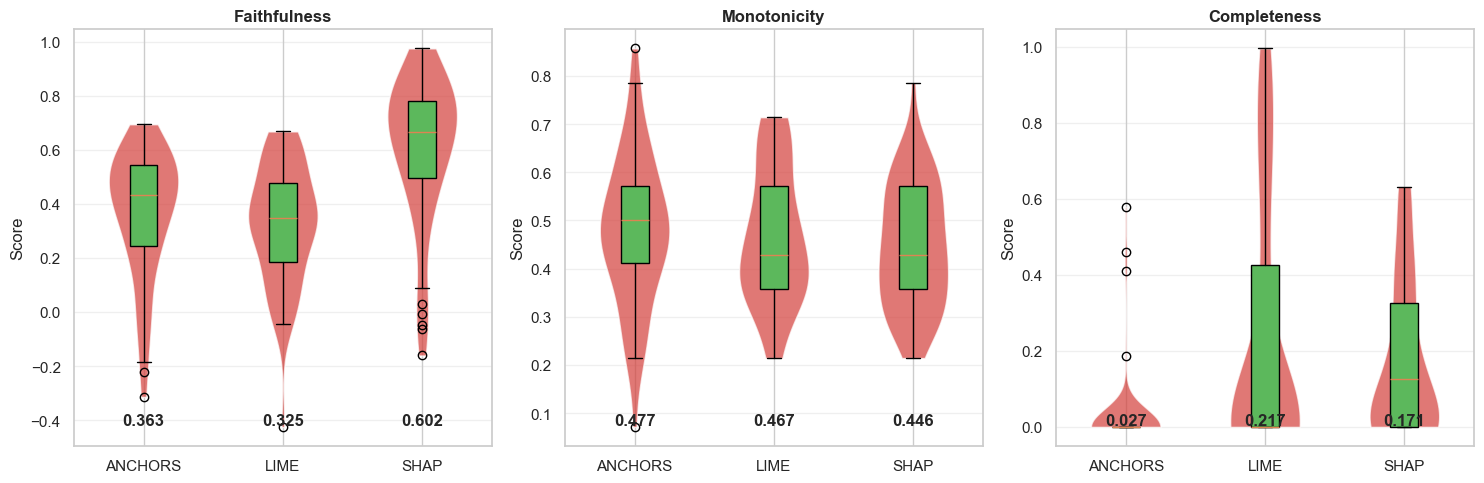

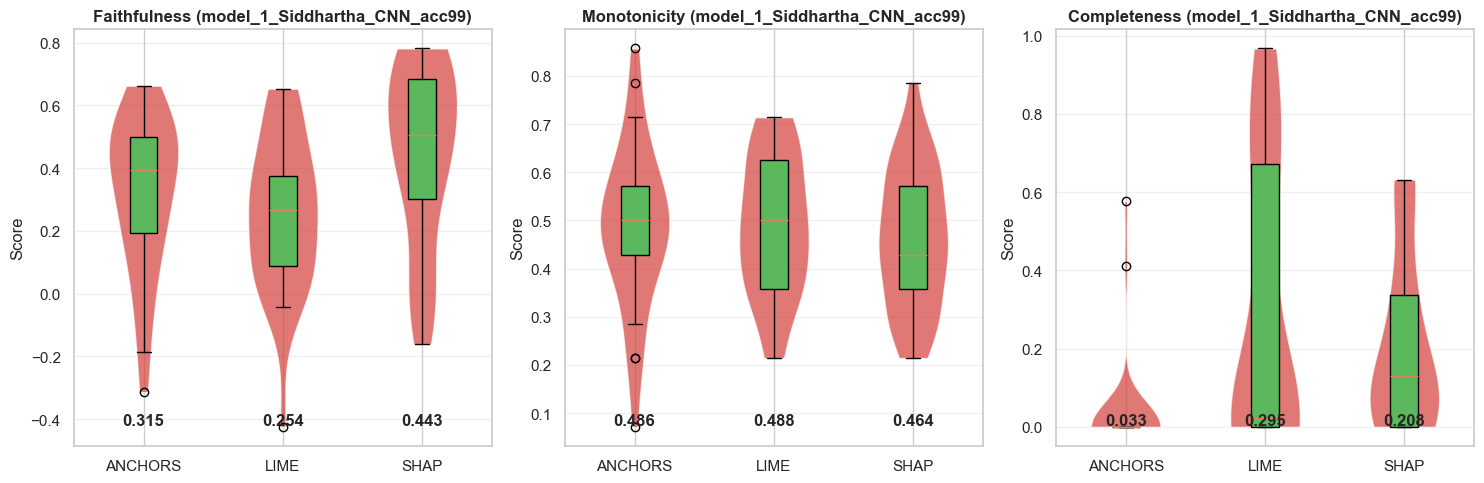

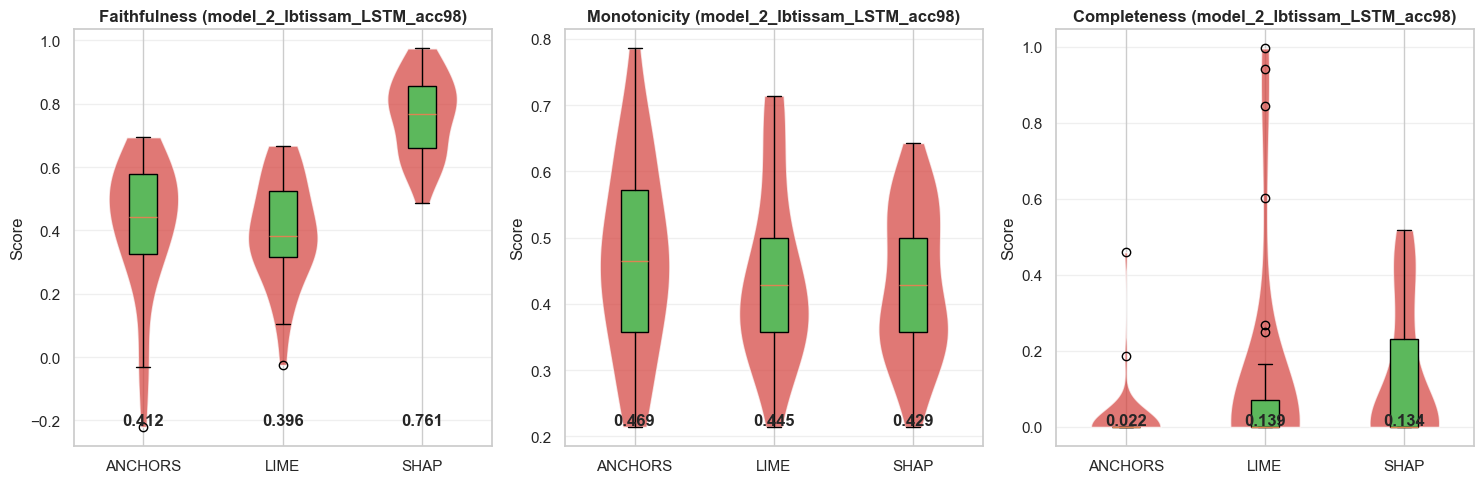

In [459]:
def plot_metric_comparisons(xai_metrics, model_name=None, common_metrics = ['Faithfulness', 'Monotonicity', 'Completeness']):
    """Plot comparison of all metrics across XAI methods
    
    Args:
        xai_metrics: Nested dictionary of metrics
        model_name: If specified, only plot this model's data
    """

    # Create figure
    fig = plt.figure(figsize=(15, 5))
    
    # For each metric
    for i, metric in enumerate(common_metrics, 1):
        ax = plt.subplot(1, 3, i)
        
        data = []
        labels = []
        xai_methods = []
        
        # If model_name is specified, only process that model
        models_to_process = [model_name] if model_name else xai_metrics.keys()
        
        # Gather all methods from all models
        for model in models_to_process:
            for method in xai_metrics[model].keys():
                if method not in xai_methods:
                    xai_methods.append(method)
        
        # Sort methods alphabetically for consistent ordering
        xai_methods.sort()
        
        # For each method, collect data from all models
        for method in xai_methods:
            method_data = []
            
            # Collect values for this method across all models
            for model in models_to_process:
                if method in xai_metrics[model] and metric in xai_metrics[model][method]:
                    method_data.extend(xai_metrics[model][method][metric])
            
            if method_data:
                data.append(method_data)
                labels.append(method.upper())
        
        # Create violin plot with boxplot inside
        if data:
            parts = plt.violinplot(data, showmeans=False, showmedians=False, showextrema=False)
            
            # Customize violin plots
            for pc in parts['bodies']:
                pc.set_facecolor('#D43F3A')
                pc.set_alpha(0.7)
            
            # Add boxplot inside violin
            boxplots = plt.boxplot(data, positions=range(1, len(data)+1), widths=0.2, 
                           patch_artist=True, boxprops=dict(facecolor='#5CB85C'))
            
            # Set labels and title
            plt.xticks(range(1, len(labels)+1), labels)
            title = f'{metric.capitalize()}'
            if model_name:
                title += f' ({model_name})'
            plt.title(title, fontweight='bold')
            plt.ylabel('Score')
            plt.grid(axis='y', alpha=0.3)
            
            # Add mean values as text
            for j, vals in enumerate(data):
                mean_val = np.mean(vals)
                plt.text(j+1, plt.ylim()[0] + 0.05 * (plt.ylim()[1] - plt.ylim()[0]), 
                        f'{mean_val:.3f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    
    # Save figure with appropriate filename
    filename = f"xai_comparison_{'_'.join(models_to_process)}.png" if model_name else "xai_comparison_all_models.png"
    plt.savefig(os.path.join(VISUALISATION_PATH, filename), dpi=600, bbox_inches='tight') if SAVE_FIGURES else None
    
    return fig

# Plot metrics for all models combined
all_models_fig = plot_metric_comparisons(xai_metrics)
plt.show()

# Plot metrics for each model separately
for model in xai_metrics.keys():
    model_fig = plot_metric_comparisons(xai_metrics, model_name=model)
    plt.show()

#### Distribution of metrics using violin plots

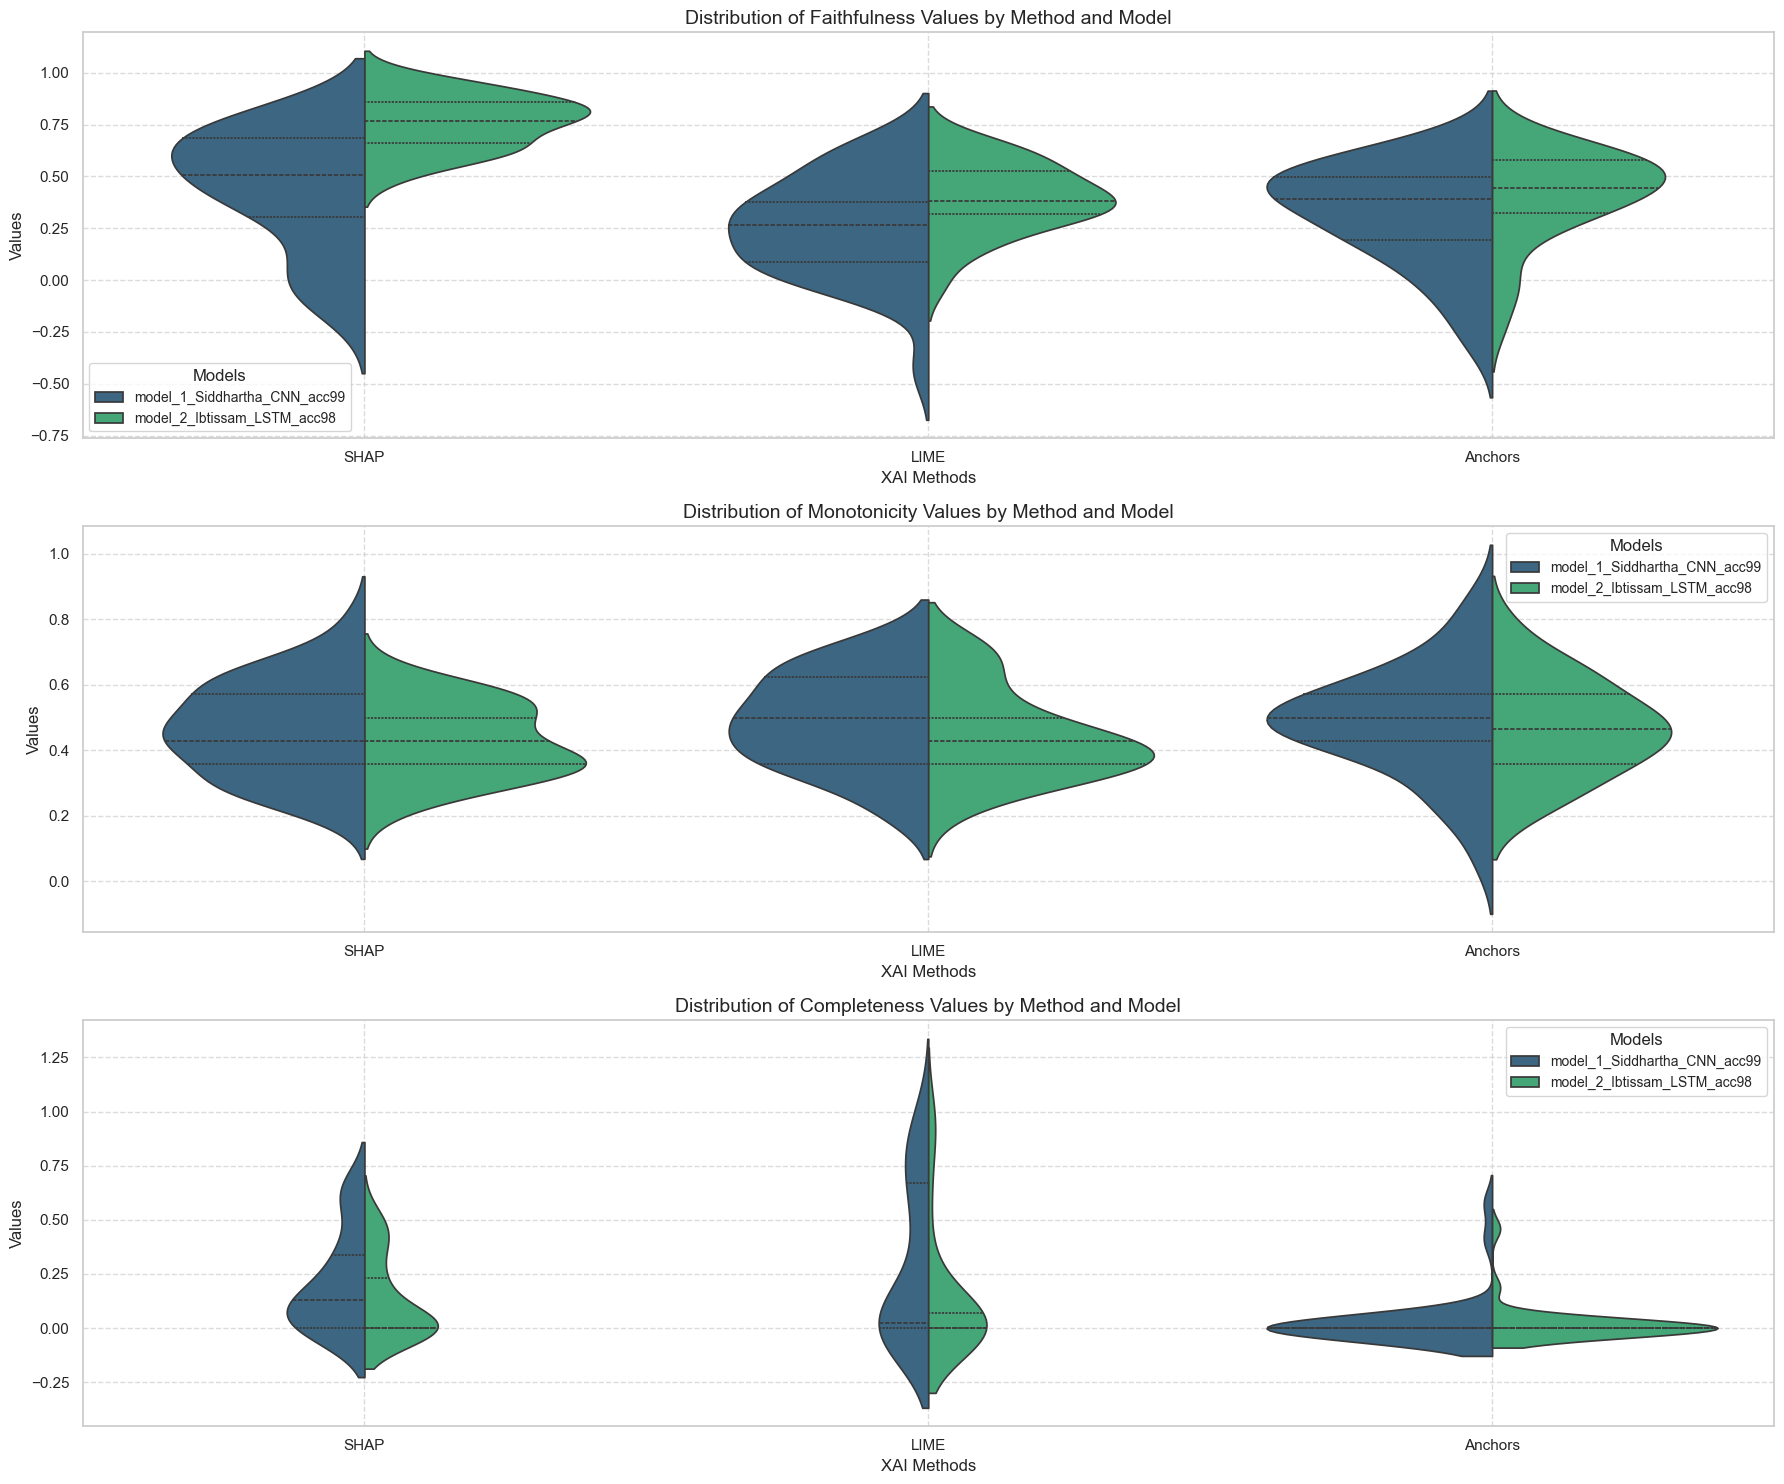

In [460]:
# Convert nested dictionary to DataFrame for easier visualisation
def prepare_metrics_df(xai_metrics):
    rows = []
    for model_name, methods_metrics in xai_metrics.items():
        for method, metrics in methods_metrics.items():
            for metric, values in metrics.items():
                for value in values:
                    rows.append({
                        'Models': model_name,
                        'Methods': method,
                        'Metrics': metric,
                        'Values': value
                    })
    return pd.DataFrame(rows)

metrics_df = prepare_metrics_df(xai_metrics)

# Create a single figure with multiple subplots
fig = plt.figure(figsize=(18, 15))
gs = gridspec.GridSpec(3, 1)

# Create subplot for each metric
for i, metric in enumerate(metrics_list):
    # Create subplot
    ax = fig.add_subplot(gs[i])
    
    # Filter data for this metric
    metric_data = metrics_df[metrics_df['Metrics'] == metric]
    
    # Create violin plot
    sns.violinplot(x='Methods', y='Values', hue='Models', 
                  data=metric_data, palette='viridis', 
                  split=True, inner='quartile', ax=ax)
    
    ax.set_title(f'Distribution of {metric} Values by Method and Model', fontsize=14)
    ax.set_ylabel('Values', fontsize=12)
    ax.set_xlabel('XAI Methods', fontsize=12)
    ax.legend(title='Models', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Save this individual subplot
    # Create a new figure with just this subplot
    fig_temp = plt.figure(figsize=(10, 6))
    canvas = FigureCanvas(fig_temp)
    ax_temp = fig_temp.add_subplot(111)
    
    # Copy the content from the original subplot
    sns.violinplot(x='Methods', y='Values', hue='Models', 
                  data=metric_data, palette='viridis', 
                  split=True, inner='quartile', ax=ax_temp)
    
    ax_temp.set_title(f'Distribution of {metric} Values by Method and Model', fontsize=14)
    ax_temp.set_ylabel('Values', fontsize=12)
    ax_temp.set_xlabel('XAI Methods', fontsize=12)
    ax_temp.legend(title='Models', fontsize=10)
    ax_temp.grid(True, linestyle='--', alpha=0.7)
    
    # Save the temporary figure
    fig_temp.tight_layout()
    fig_temp.savefig(os.path.join(VISUALISATION_PATH, f"violin_plot_{metric}.png"), dpi=600, bbox_inches='tight') if SAVE_FIGURES else None
    plt.close(fig_temp)  # Close the temporary figure

# Adjust the layout for the combined figure
plt.tight_layout()

# Save the combined figure as well
fig.savefig(os.path.join(VISUALISATION_PATH, f"violin_plots_combined.png"), dpi=600, bbox_inches='tight') if SAVE_FIGURES else None

# Display the combined plot
plt.show()

#### Bar Plot for Metric Mean Values

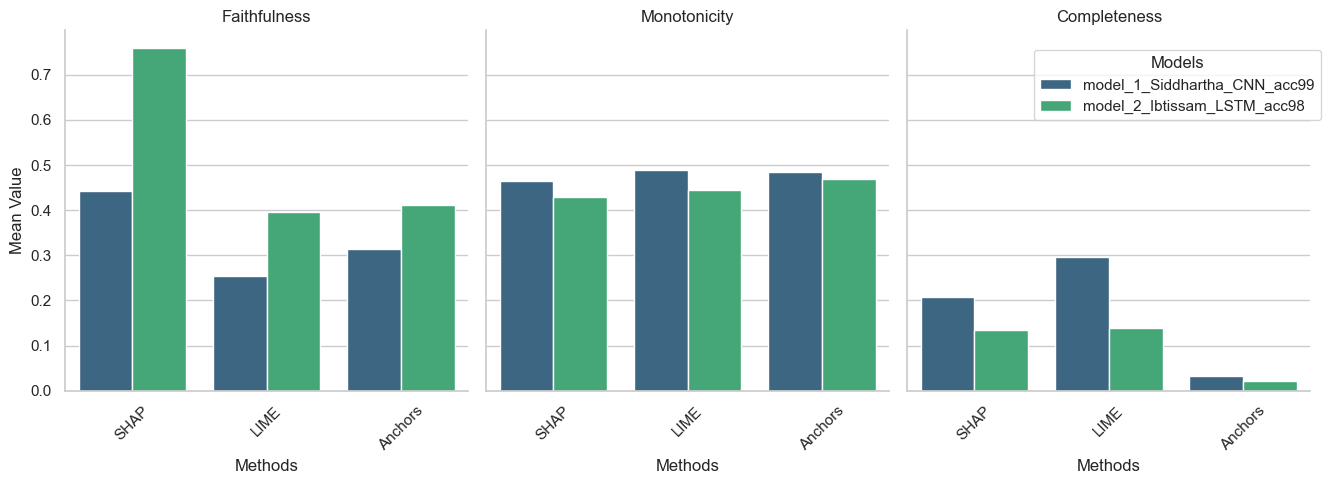

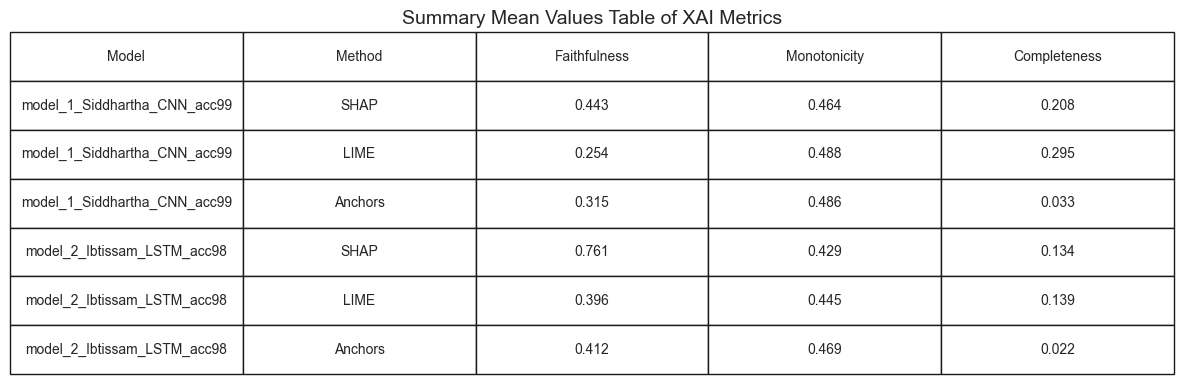

In [461]:
stat_type = 'mean'
plot_data = summary_metrics.reset_index()

# Original catplot visualisation
g = sns.catplot(
    data=plot_data, 
    kind="bar",
    x="Methods", y=stat_type, hue="Models",
    col="Metrics", 
    height=5, aspect=0.7,
    palette="viridis",
    legend_out=True
)

sns.move_legend(g, 'upper right', bbox_to_anchor=(1, 0.9), title='Models', frameon=True)
g.set_xticklabels(rotation=45)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Methods", f"{stat_type.capitalize()} Value")
plt.tight_layout()
g.savefig(os.path.join(VISUALISATION_PATH, f'catplot_{stat_type}.png'), dpi=600, bbox_inches='tight') if SAVE_FIGURES else None
plt.show()

# Create a separate visualisation just for the summary table
plt.figure(figsize=(12, 4))
ax = plt.subplot(111)
ax.axis('off')

# Create and style the table
table_data = []
for model_name in plot_data['Models'].unique():
    for method in plot_data['Methods'].unique():
        row = [model_name, method]
        for metric in metrics_list:
            value = plot_data[(plot_data['Models'] == model_name) & 
                             (plot_data['Methods'] == method) & 
                             (plot_data['Metrics'] == metric)][stat_type].values
            row.append(f"{value[0]:.3f}" if len(value) > 0 else "N/A")
        table_data.append(row)

table = plt.table(
    cellText=table_data,
    colLabels=['Model', 'Method', *metrics_list],
    loc='center',
    cellLoc='center',
    bbox=[0, 0, 1, 1]
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.title(f'Summary {stat_type.capitalize()} Values Table of XAI Metrics', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(VISUALISATION_PATH, f'summary_table_{stat_type}.png'), dpi=600, bbox_inches='tight') if SAVE_FIGURES else None
plt.show()

#### Radar Charts

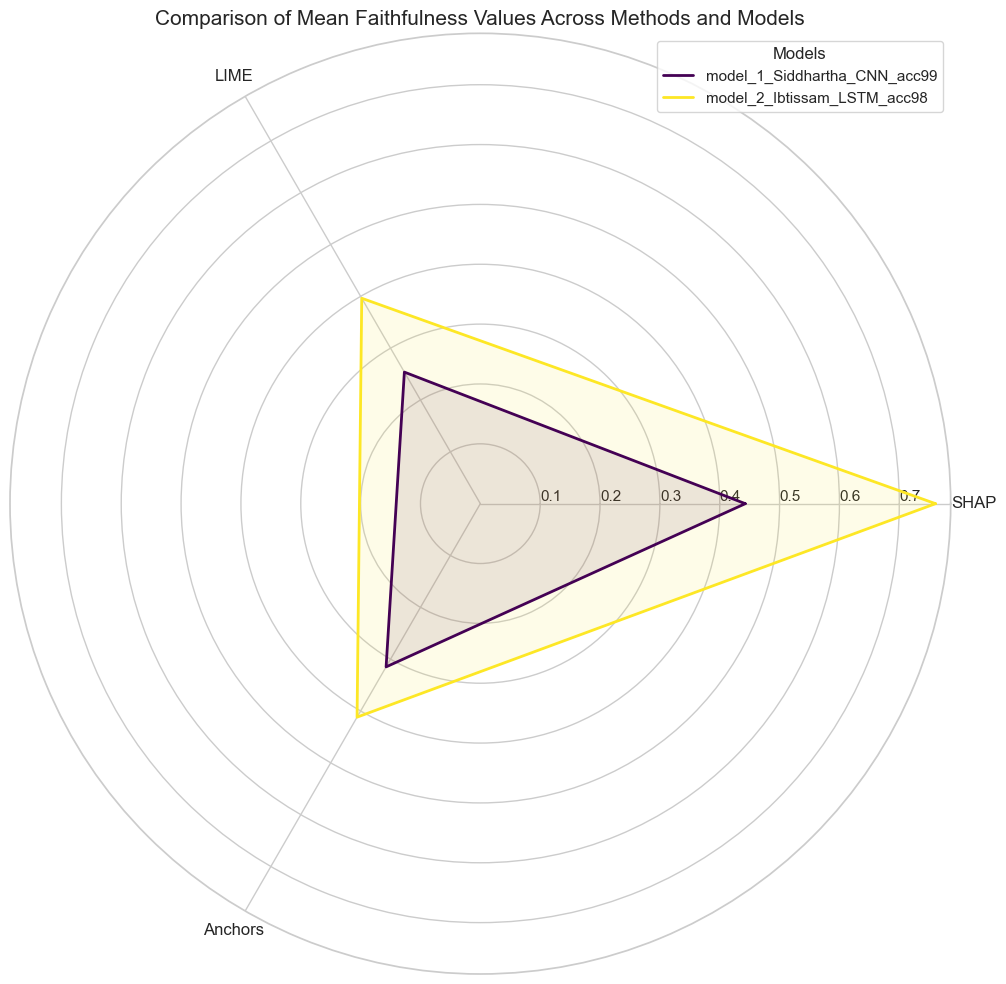

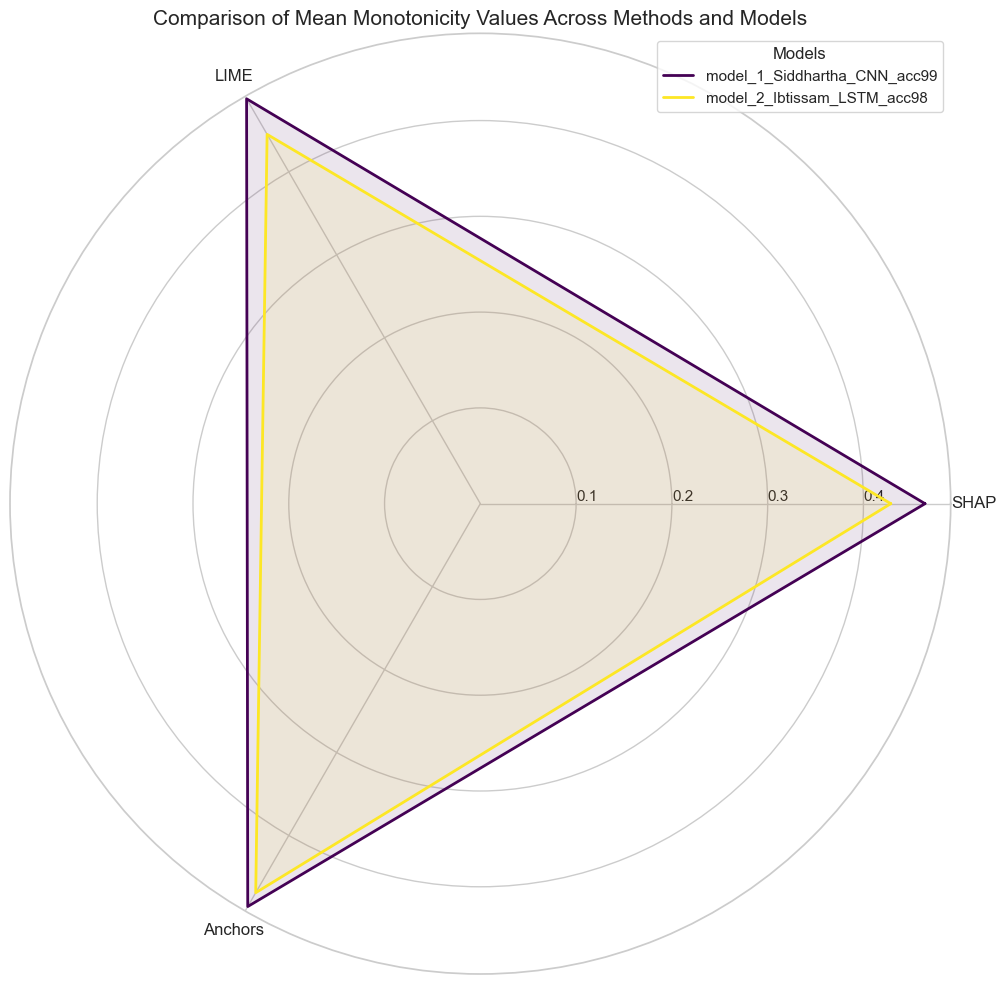

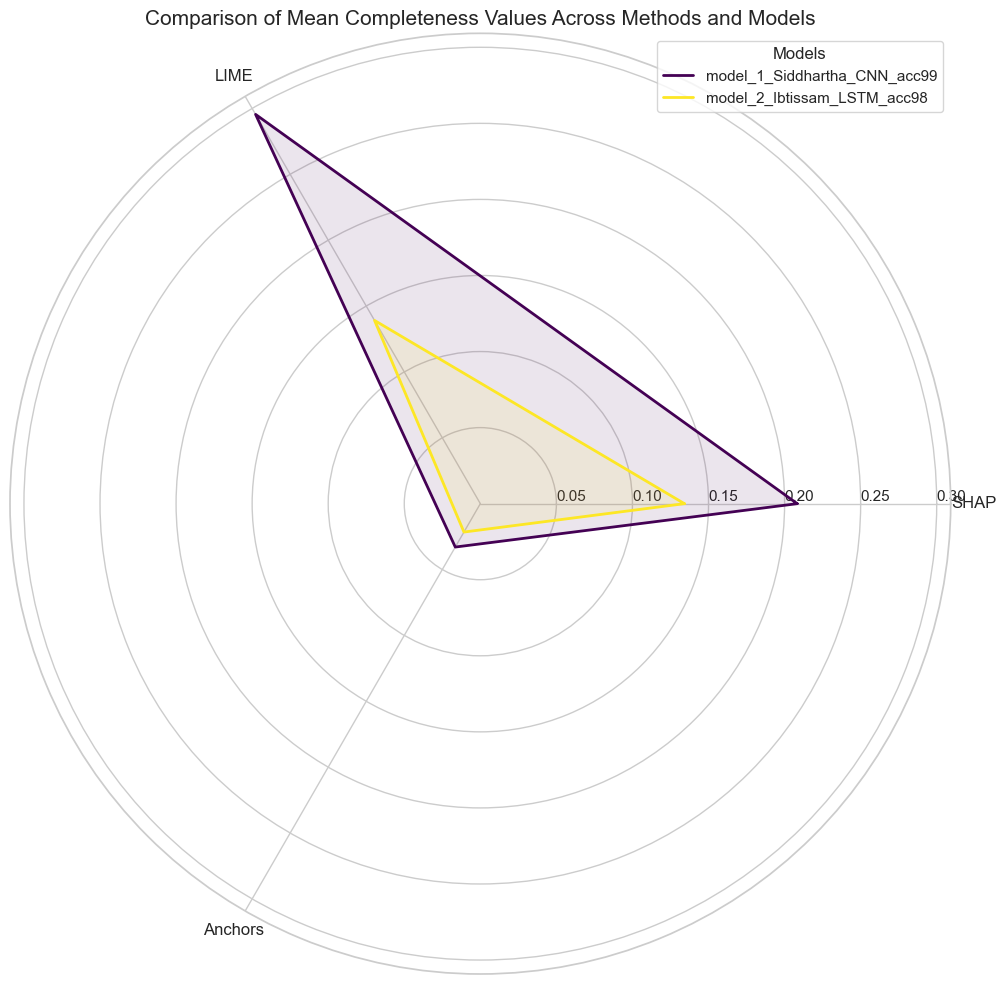

In [462]:
stat_type = 'mean'

def radar_chart(df, metric_to_plot='mean'):
    # Get unique `Models` and `Methods` columns
    models = df.index.get_level_values('Models').unique()
    methods = df.index.get_level_values('Methods').unique()
    
    # Number of variables (methods)
    N = len(methods)
    
    # Angles for each method
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Set figure size
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True))
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], methods, size=12)
    
    # Draw the outlines for different models
    colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
    
    for i, model in enumerate(models):
        # Extract data for this model across all methods
        values = []
        for method in methods:
            try:
                # Get the mean value for this model and method
                value = df.loc[(model, method), metric_to_plot]
                values.append(value)
            except KeyError:
                # Handle missing combinations
                values.append(0)
        
        values += values[:1]  # Close the loop
        
        # Plot values
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])
    
    # Improve the legend
    plt.legend(loc='upper right', title='Models')
    
    # Add grid
    ax.set_rlabel_position(0)
    plt.grid(True)
    
    return fig

for metric in metrics_list:
    # Filter data for this metric
    metric_data = summary_metrics.xs(metric, level='Metrics')
    
    # Create radar chart
    radar_fig = radar_chart(metric_data, stat_type)
    plt.title(f'Comparison of Mean {metric} Values Across Methods and Models', size=15)
    plt.tight_layout()
    plt.savefig(os.path.join(VISUALISATION_PATH, f'radar_chart_{metric}_{stat_type}.png'), dpi=600, bbox_inches='tight') if SAVE_FIGURES else None
    plt.show()

In [465]:
features

['merchant',
 'category',
 'amt',
 'gender',
 'lat',
 'long',
 'city_pop',
 'merch_lat',
 'merch_long',
 'age',
 'age_group',
 'dist',
 'hour',
 'day_of_week',
 'month']

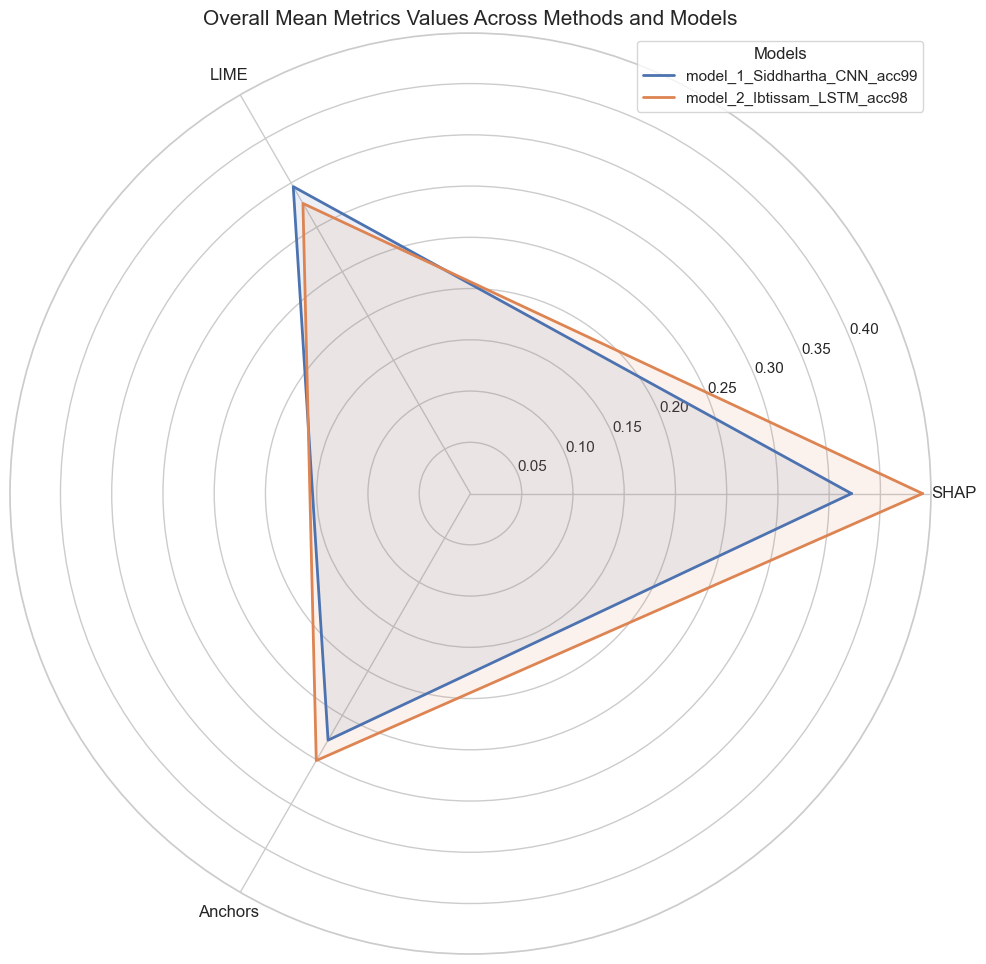

In [463]:
stat_type = 'mean'

def radar_chart(df, metric_to_plot='mean'):
    # Get unique models and methods
    models = df.index.get_level_values('Models').unique()
    methods = df.index.get_level_values('Methods').unique()
    
    # Number of variables
    N = len(methods)
    
    # What will be the angle of each axis in the plot (divide the plot / number of variables)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Set figure size
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], methods, size=12)
    
    # Draw the outlines for different models
    for model in models:
        values = [df.xs((model, method), level=('Models', 'Methods'))[metric_to_plot].mean() 
                 for method in methods]
        values += values[:1]  # Close the loop
        
        # Plot values
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', title='Models')
    plt.title(f'Overall {metric_to_plot.capitalize()} Metrics Values Across Methods and Models', size=15)
    
    return fig

# Create radar chart for mean values
radar_fig = radar_chart(summary_metrics, stat_type)
plt.tight_layout()
plt.savefig(os.path.join(VISUALISATION_PATH, f'radar_chart_overall_mean.png'), dpi=600, bbox_inches='tight') if SAVE_FIGURES else None
plt.show()

#### Mean Metric Values across all Confidence Bins

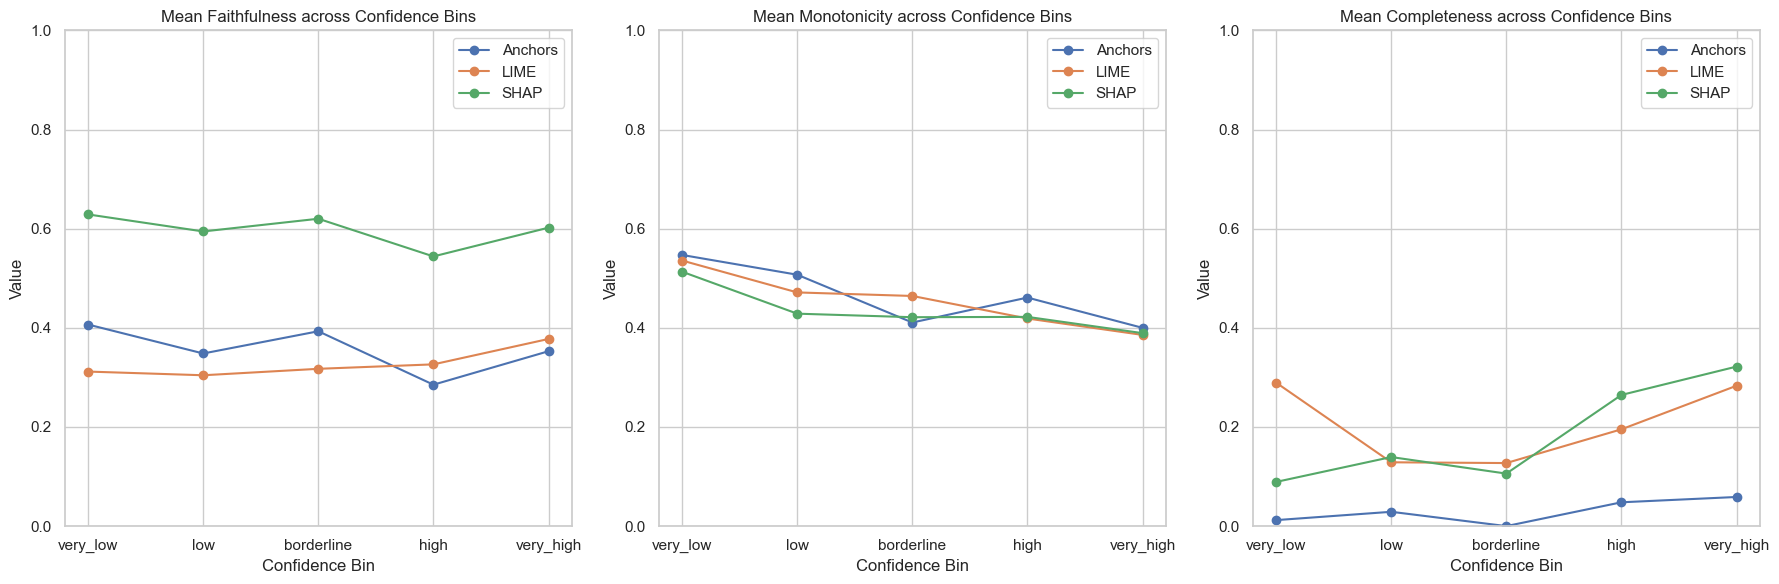

In [464]:
confidence_bins = ['very_low', 'low', 'borderline', 'high', 'very_high']
results = {}
stat_type = 'mean'

for bin in confidence_bins:
    # Filter metrics for this bin
    filtered_metrics, filtered_indices = filter_metrics(samples, xai_metrics, confidence_bins=[bin])
    filtered_summary_metrics = get_summary_metrics(filtered_metrics)
    
    # Store the pivot table result
    results[bin] = filtered_summary_metrics.pivot_table(values=stat_type, index='Methods', columns='Metrics')

# Create subplots for each metric
fig, axes = plt.subplots(1, len(metrics_list), figsize=(18, 6))
for i, metric in enumerate(metrics_list):
    # Create a DataFrame for this metric across all bins
    metric_df = pd.DataFrame({
        method: [results[bin].loc[method, metric] for bin in confidence_bins]
        for method in results['very_low'].index
    }, index=confidence_bins)
    
    metric_df.plot(marker='o', ax=axes[i])
    axes[i].set_title(f'{stat_type.capitalize()} {metric} across Confidence Bins')
    axes[i].set_ylim(0, 1)
    axes[i].set_xlabel('Confidence Bin')
    axes[i].set_ylabel('Value')
    
plt.tight_layout()
plt.savefig(os.path.join(VISUALISATION_PATH, f'metrics_by_confidence.png'), dpi=600, bbox_inches='tight') if SAVE_FIGURES else None
plt.show()